In [47]:
import numpy as np
import scipy.linalg
import scipy.signal
import networkx as nx
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

from scipy.linalg import expm
from scipy.linalg import null_space

from general_graph_utils import *

In [2]:
plt.rc("text", usetex=False)
plt.rc("font", family = "serif",size=14)
plt.rc("figure",figsize=(10,8))
%config InlineBackend.figure_format = 'retina'

In this work, we seek to identify how oscillations change as a function of varying ATP.

## Oscillations on 3-vertex graph

Here, we confirm the results published in Barato, Seifert 2017 for oscillations in the correlation function $C_{1,1}(t)$ for a unicyclic network with $N=3$. 

Without loss of generality, let the first nontrivial eigenvalue of the transition matrix be given by $\lambda = -X_R \pm X_I i$. $\lambda$ gives us the oscillation decay time $X^{-1}_R$ and oscillation period $2 \pi/X_I$. The coherence of the oscillations is characterized by the ratio $\mathcal{R} = X_I/X_R$. 

Barato and Seifert's work tells us the following about unicyclic networks:

1. The number of coherent oscillations is given by the quantity $\mathcal{R}/2\pi$.
2. $\mathcal{R}$ is maximized for uniform transition rates and is bounded by the thermodynamic force $\mathcal{A}$ and the number of states in the network $N$. We assume that the affinity $\mathcal{A}$ is fixed.

First, we define a few functions specific to a 3-vertex graph to speed up the calculations.

In [3]:
def affinity(k12,k21,k23,k32,k31,k13):
    aff = np.log((k12*k23*k31)/(k13*k32*k21))
    return aff

In [4]:
# Transition rate matrix W
def transition_matrix(k12,k21,k23,k32,k31,k13):
    W = np.array([
        [-k12 - k13, k21, k31],  # Transition rates from E1
        [k12, -k21 - k23, k32],  # Transition rates from E2
        [k13, k23, -k31 - k32],  # Transition rates from E3
    ])
    return W

In [5]:
# Function to compute the correlation function C(t)
def correlation_function(t, W):
    exp_Wt = expm(W * t) # Compute the matrix exponential e^(Wt)
    p = [1,0,0]
    return (exp_Wt[0]*p)[0] # e^(Wt)[11] Prob of being in 1 at time t given was in 1 at time 0

When we set all rates equal to $1.0$, detailed balance is fulfilled and $\mathcal{A} = 0$. $X_I$ is also $0$, and thus there are no oscillations in the correlation function.

In [6]:
k12, k21 = 1.0, 1.0  # Rates between E1 and E2
k23, k32 = 1.0, 1.0  # Rates between E2 and E3
k31, k13 = 1.0, 1.0  # Rates between E3 and E1

# force
print("force: " + str(affinity(k12,k21,k23,k32,k31,k13)))

# eigenvalues of W
W = transition_matrix(k12,k21,k23,k32,k31,k13)
eigvals, eigvecs = scipy.linalg.eig(W)
print("eigenvalues: " + str(eigvals))

x_i = np.abs(np.sort(eigvals)[-2].imag)
x_r = np.abs(np.sort(eigvals)[-2].real)

# decay time
#tau = 1/x_r
#print("decay time: " + str(tau))

# oscillation period
#omega = (2*math.pi)/x_i
#print("period: " + str(omega))

# number of coherent oscillations
R = x_i/x_r
print("number coherent oscillations: " + str(R/2*math.pi))

# Time points for the plot
times = np.linspace(0, 4, 500)  # time from 0 to 4 with 500 points
# Compute C(t) for each time point
correlation_values = [correlation_function(t, W) for t in tqdm(times)]

force: 0.0
eigenvalues: [-3.0000000e+00+0.j  4.4408921e-16+0.j -3.0000000e+00+0.j]
number coherent oscillations: 0.0


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 140.33it/s]


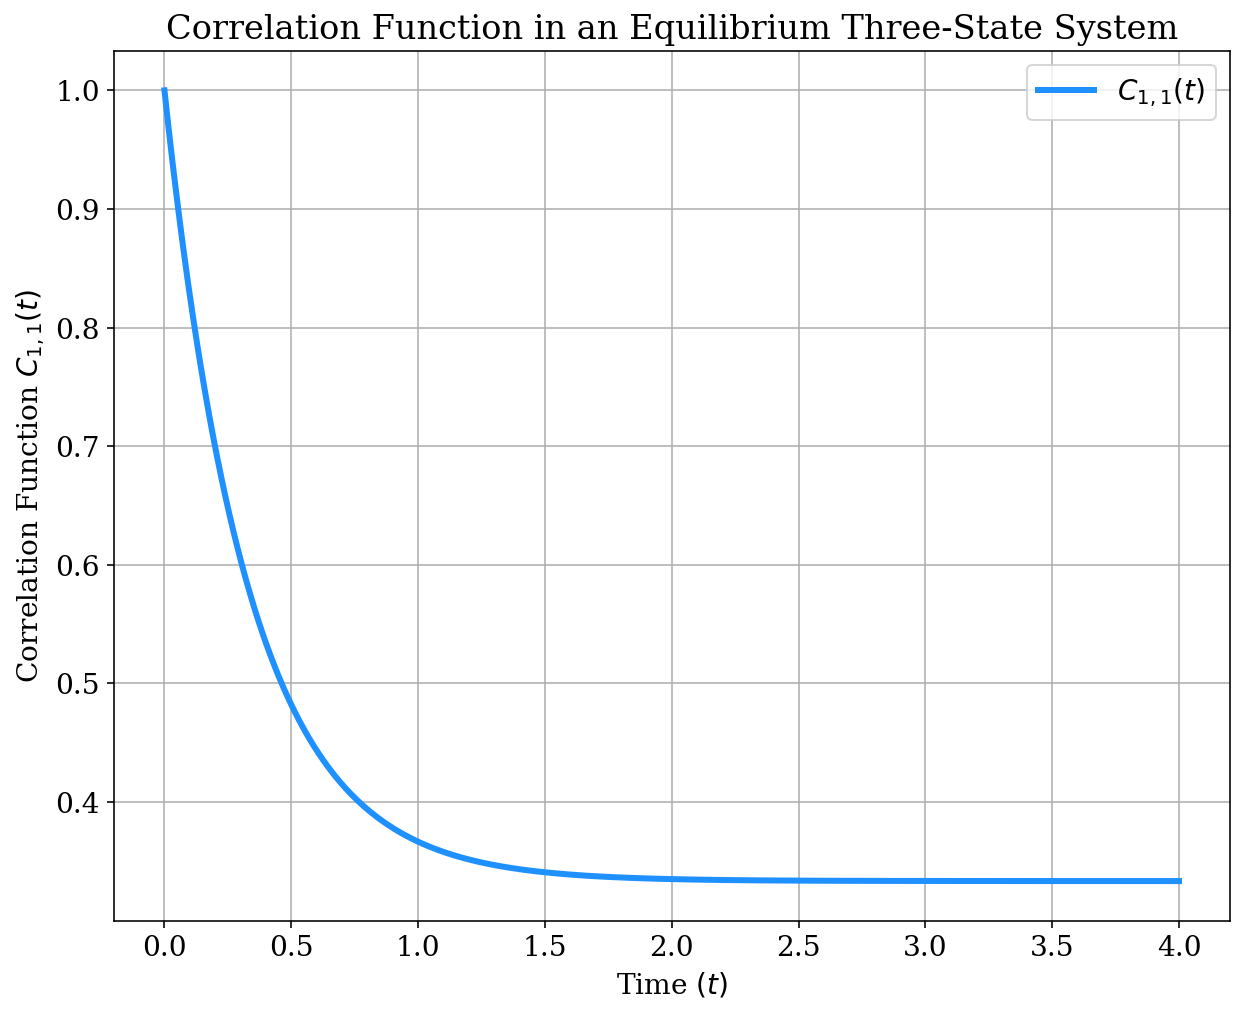

In [7]:
plt.plot(times, correlation_values, label=r'$C_{1,1}(t)$', linewidth=3, color='dodgerblue')
plt.xlabel(r'Time $(t)$')
plt.ylabel(r'Correlation Function $C_{1,1}(t)$')
plt.title('Correlation Function in an Equilibrium Three-State System')
plt.legend()
plt.grid()
plt.show()

Next, we go through a few different cases for the 3-vertex graph to get a sense of how the oscillation coherence changes as the affinity changes. Here, we choose rates such that $\mathcal{A}$ = 1.0. Because $X_I=0$ for this choice of rates, we again have no oscillations in $C_{1,1}(t)$.

In [8]:
k12, k21 = 1.0, 2.0  # Rates between E1 and E2
k23, k32 = 1.5, 1.0  # Rates between E2 and E3
k31, k13 = 2.0, 0.5  # Rates between E3 and E1

# force
print("force: " + str(affinity(k12,k21,k23,k32,k31,k13)))

# eigenvalues of W
W = transition_matrix(k12,k21,k23,k32,k31,k13)
eigvals, eigvecs = scipy.linalg.eig(W)
print("eigenvalues: " + str(np.sort(eigvals)))

x_i = np.abs(np.sort(eigvals)[-2].imag)
x_r = np.abs(np.sort(eigvals)[-2].real)

# decay time
#tau = 1/x_r
#print("decay time: " + str(tau))

# oscillation period
#omega = (2*math.pi)/x_i
#print("period: " + str(omega))

# number of coherent oscillations
R = x_i/x_r
print("number coherent oscillations: " + str(R/2*math.pi))

# Time points for the plot
times = np.linspace(0, 4, 500)  # time from 0 to 4 with 500 points
# Compute C(t) for each time point
correlation_values = [correlation_function(t, W) for t in times]

force: 1.0986122886681098
eigenvalues: [-4.5000000e+00+0.j -3.5000000e+00+0.j  4.4408921e-16+0.j]
number coherent oscillations: 0.0


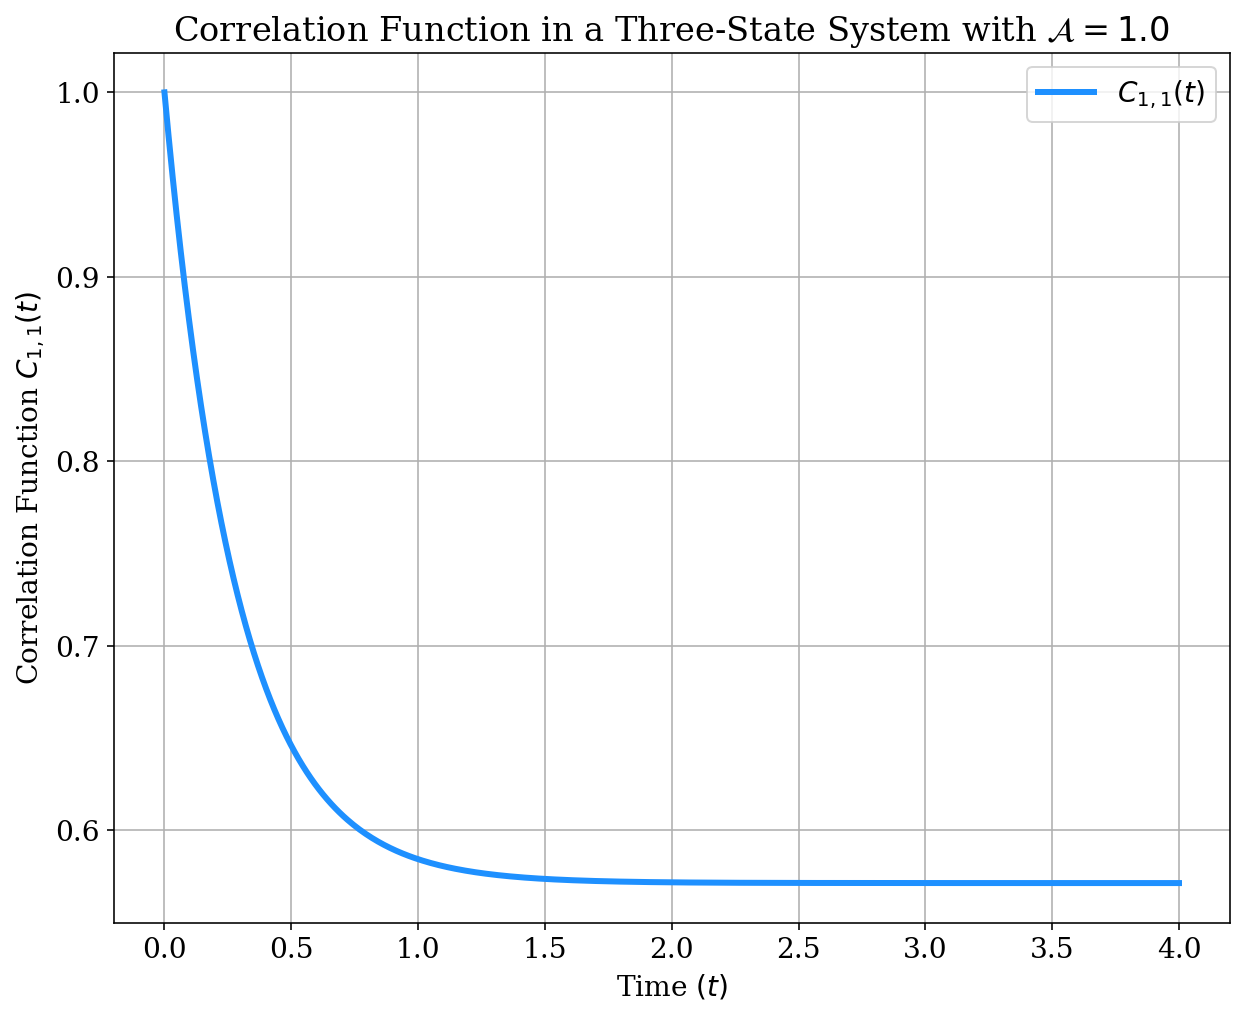

In [9]:
plt.plot(times, correlation_values, label=r'$C_{1,1}(t)$', linewidth=3, color='dodgerblue')
plt.xlabel(r'Time $(t)$')
plt.ylabel(r'Correlation Function $C_{1,1}(t)$')
plt.title(r'Correlation Function in a Three-State System with $\mathcal{A} = 1.0$')
plt.legend()
plt.grid()
plt.show()

Here, we choose transition rates for which $X_I \neq 0$ (chosen by sampling scheme below the correlation plots). We can see the formation of an oscillation here.

In [10]:
# Oscillatory transition rates
k13, k12, k23, k21, k31, k32 = 1.160000e-03, 1.330766e+01, 8.319220e+00, 3.330000e-03, 1.046221e+01, 1.978970e+00

# force
print("force: " + str(affinity(k12,k21,k23,k32,k31,k13)))

# eigenvalues of W
W = transition_matrix(k12,k21,k23,k32,k31,k13)
eigvals, eigvecs = scipy.linalg.eig(W)
print("eigenvalues: " + str(eigvals))

x_i = np.abs(np.sort(eigvals)[-2].imag)
x_r = np.abs(np.sort(eigvals)[-2].real)

# decay time
tau = 1/x_r
print("decay time: " + str(tau))

# oscillation period
omega = (2*math.pi)/x_i
print("period: " + str(omega))

# number of coherent oscillations
R = x_i/x_r
print("number coherent oscillations: " + str(R/2*math.pi))

# Time points for the plot
times = np.linspace(0, 1.5, 500)  # time from 0 to 1.5 with 500 points
# Compute C(t) for each time point
correlation_values = [correlation_function(t, W) for t in times]

force: 18.836219768636184
eigenvalues: [ 3.58090794e-15+0.j         -1.70362750e+01+8.55151942j
 -1.70362750e+01-8.55151942j]
decay time: 0.058698277645788215
period: 0.734744903218277
number coherent oscillations: 0.7884760776858771


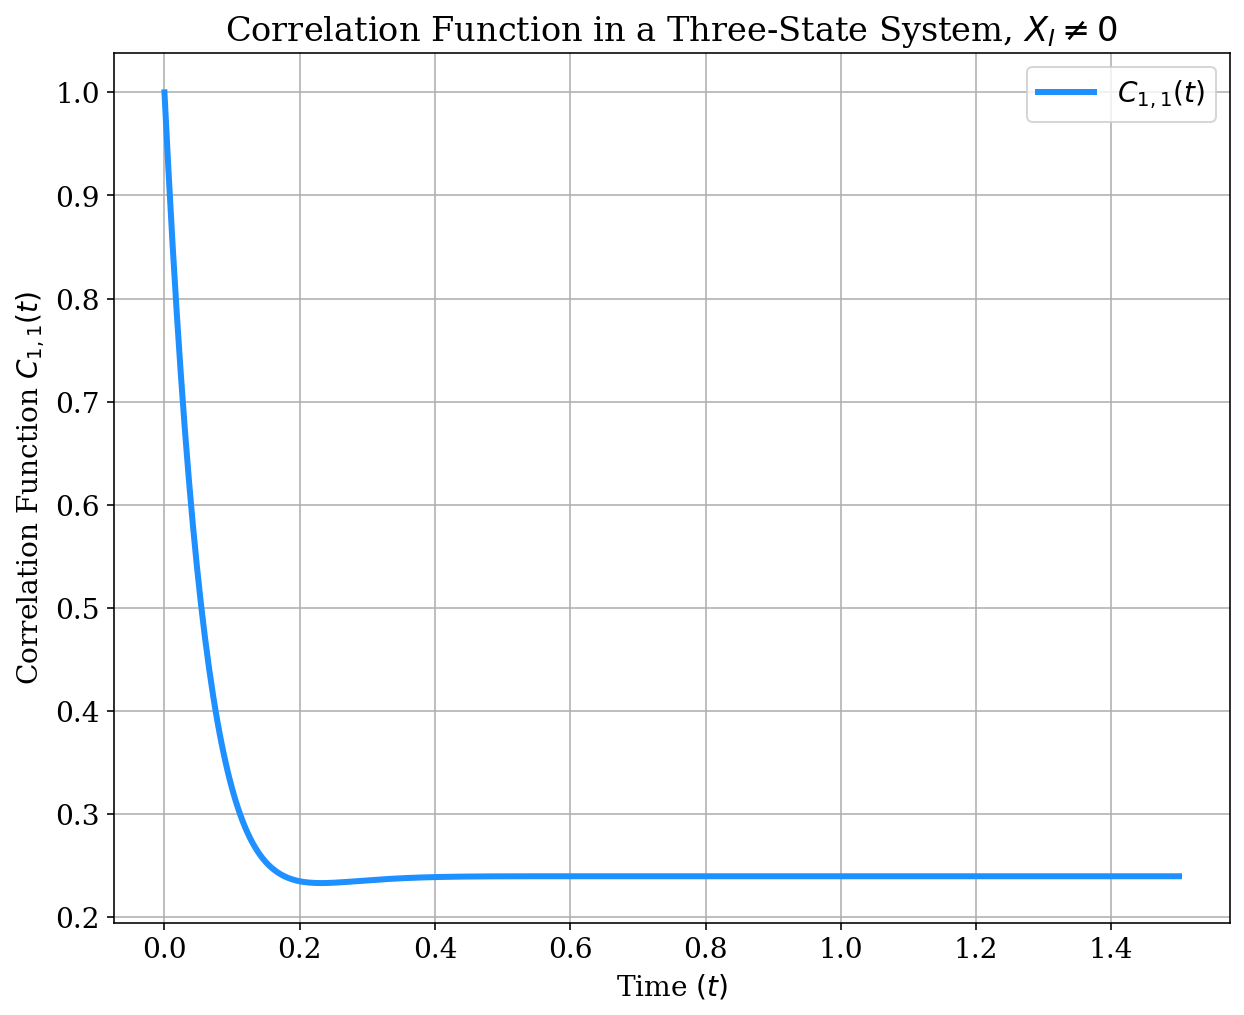

In [11]:
plt.plot(times, correlation_values, label=r'$C_{1,1}(t)$', linewidth=3, color='dodgerblue')
plt.xlabel(r'Time $(t)$')
plt.ylabel(r'Correlation Function $C_{1,1}(t)$')
plt.title(r'Correlation Function in a Three-State System, $X_I \neq 0$')
plt.legend()
plt.grid()
plt.show()

Here, we examine the case where the network is totally unidrectional (i.e. all transition rates going in one direction around the cycle are set to 0). According to Barato and Seifert, this is the regime where the number of coherent oscillations is maximized for $N=3$.

In [12]:
# Oscillatory transition rates
k12, k21 = 2.0, 0  # Rates between E1 and E2
k23, k32 = 2.0, 0  # Rates between E2 and E3
k31, k13 = 2.0, 0  # Rates between E3 and E1

# force
#print("force: " + str(affinity(k12,k21,k23,k32,k31,k13)))

# eigenvalues of W
W = transition_matrix(k12,k21,k23,k32,k31,k13)
eigvals, eigvecs = scipy.linalg.eig(W)
print("eigenvalues: " + str(eigvals))

x_i = np.abs(np.sort(eigvals)[-2].imag)
x_r = np.abs(np.sort(eigvals)[-2].real)

# decay time
tau = 1/x_r
print("decay time: " + str(tau))

# oscillation period
omega = (2*math.pi)/x_i
print("period: " + str(omega))

# number of coherent oscillations
R = x_i/x_r
print("number coherent oscillations: " + str(R/2*math.pi))

# Time points for the plot
times = np.linspace(0, 4, 500)  # time from 0 to 4 with 500 points
# Compute C(t) for each time point
correlation_values = [correlation_function(t, W) for t in times]

eigenvalues: [-3.00000000e+00+1.73205081j -3.00000000e+00-1.73205081j
 -6.48686449e-17+0.j        ]
decay time: 0.3333333333333333
period: 3.627598728468435
number coherent oscillations: 0.906899682117109


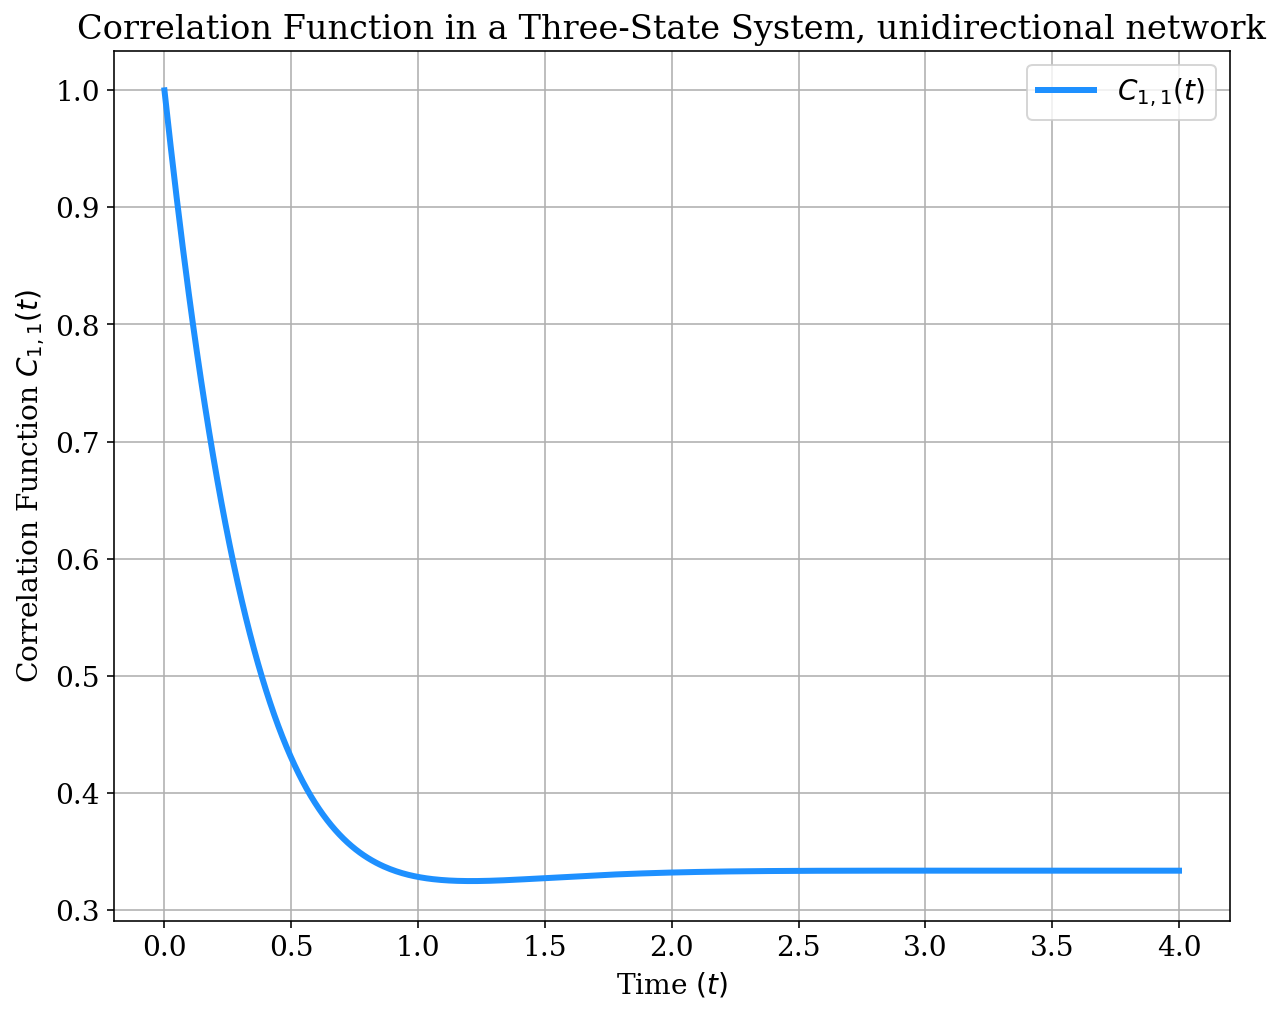

In [13]:
plt.plot(times, correlation_values, label=r'$C_{1,1}(t)$', linewidth=3, color='dodgerblue')
plt.xlabel(r'Time $(t)$')
plt.ylabel(r'Correlation Function $C_{1,1}(t)$')
plt.title(r'Correlation Function in a Three-State System, unidirectional network')
plt.legend()
plt.grid()
plt.show()

Here, we replicate the conditions in Barato and Seifert's work exactly, setting all reverse transition rates equal to $1.0$ and all forward transition rates equal to $20.0$, so the force is large.

In [14]:
# Oscillatory transition rates
k12, k21 = 20.0, 1.0  # Rates between E1 and E2
k23, k32 = 20.0, 1.0  # Rates between E2 and E3
k31, k13 = 20.0, 1.0  # Rates between E3 and E1

# force
print("force: " + str(affinity(k12,k21,k23,k32,k31,k13)))

# eigenvalues of W
W = transition_matrix(k12,k21,k23,k32,k31,k13)
eigvals, eigvecs = scipy.linalg.eig(W)
print("eigenvalues: " + str(eigvals))

x_i = np.abs(np.sort(eigvals)[-2].imag)
x_r = np.abs(np.sort(eigvals)[-2].real)

# decay time
tau = 1/x_r
print("decay time: " + str(tau))

# oscillation period
omega = (2*math.pi)/x_i
print("period: " + str(omega))

# number of coherent oscillations
R = x_i/x_r
print("number coherent oscillations: " + str(R/2*math.pi))

# Time points for the plot
times = np.linspace(0, 1, 500)  # time from 0 to 1 with 500 points
# Compute C(t) for each time point
correlation_values = [correlation_function(t, W) for t in times]

force: 8.987196820661973
eigenvalues: [-3.49536271e-15 +0.j         -3.15000000e+01+16.45448267j
 -3.15000000e+01-16.45448267j]
decay time: 0.03174603174603172
period: 0.3818524977335192
number coherent oscillations: 0.8205282838202415


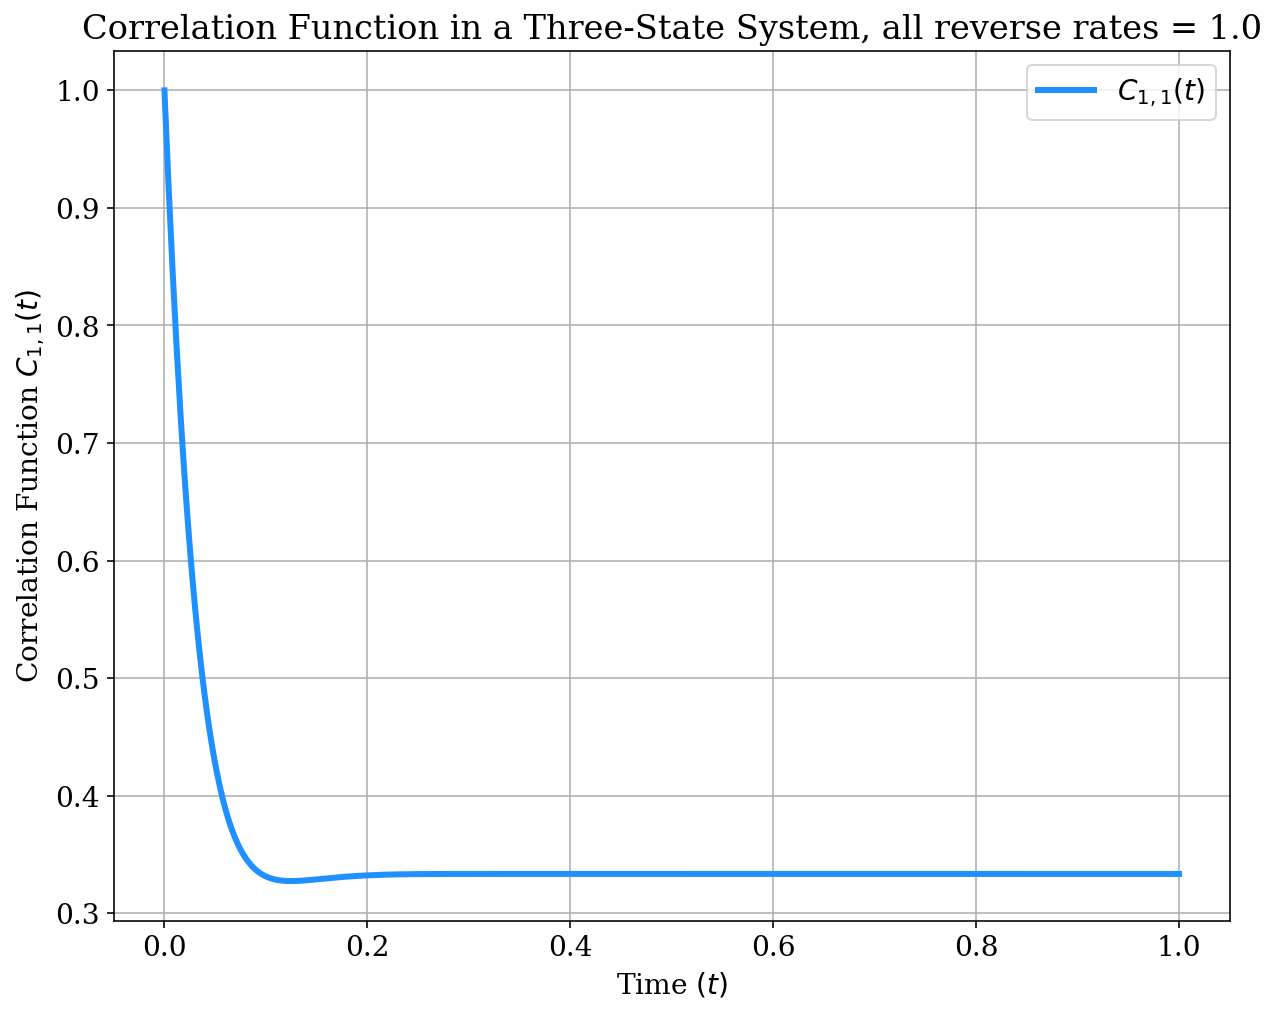

In [15]:
plt.plot(times, correlation_values, label=r'$C_{1,1}(t)$', linewidth=3, color='dodgerblue')
plt.xlabel(r'Time $(t)$')
plt.ylabel(r'Correlation Function $C_{1,1}(t)$')
plt.title(r'Correlation Function in a Three-State System, all reverse rates = 1.0')
plt.legend()
plt.grid()
plt.show()

Our simulation results suggest that the maximal number of coherent oscillations for $N=3$ appears to be $0.91$. For $N=3$, we can work with this system analytically.

## Sampling parameters for 3-vertex graph that have complex eigenvalues 

What parameter sets give you complex eigenvalues?

In [10]:
G = nx.DiGraph()
G_size = 3
nodes = np.arange(1,G_size+1,step=1)
G.add_nodes_from(nodes)

G.add_edge(1,3)
G.add_edge(3,1)
G.add_edge(2,3)
G.add_edge(3,2)
G.add_edge(1,2)
G.add_edge(2,1)


G_ud = nx.Graph()
G_ud.add_node(1)
G_ud.add_node(2)
G_ud.add_node(3)
G_ud.add_edge(3, 2)
G_ud.add_edge(2, 3)
G_ud.add_edge(1, 2)
G_ud.add_edge(2, 1)
G_ud.add_edge(1, 3)
G_ud.add_edge(3, 1)

In [11]:
node_list = get_nodes(G)
num_nodes = G_size
edge_list = get_edges(G)

# not needed for 3-cycle graph but we need the data structures
cycle_list = get_cycles(G_ud)
num_cycles = len(cycle_list)

In [12]:
label_dict, label_list = get_labels(G)

In [19]:
label_dict

{(1, 3): 0.00787,
 (1, 2): 305.34473,
 (2, 3): 0.1317,
 (2, 1): 0.08413,
 (3, 1): 3.40019,
 (3, 2): 39.9569}

In [20]:
all_labels = np.zeros((1000,6))
all_eigvals_real = np.zeros((1000,3))
all_eigvals_complex = np.zeros((1000,3))
all_affinities = np.zeros((1000,1))

In [21]:
for i in range(1000):
    label_dict, label_list = get_labels(G)
    all_labels[i] = label_list
    cycle_edges_forward,cycle_edges_backward,cycle_labels_forward,cycle_labels_backward = get_cycle_labels_edges(cycle_list,label_dict)
    products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)
    total_affinities = calculate_affinities(products_f, products_b, cycle_list)
    all_affinities[i] = total_affinities
    L = Laplacian_all(edge_list,label_list,node_list)
    eigvals, eigvecs = scipy.linalg.eig(L)
    eigvals_sorted = np.sort(eigvals)
    all_eigvals_real[i] = eigvals_sorted.real
    all_eigvals_complex[i] = eigvals_sorted.imag

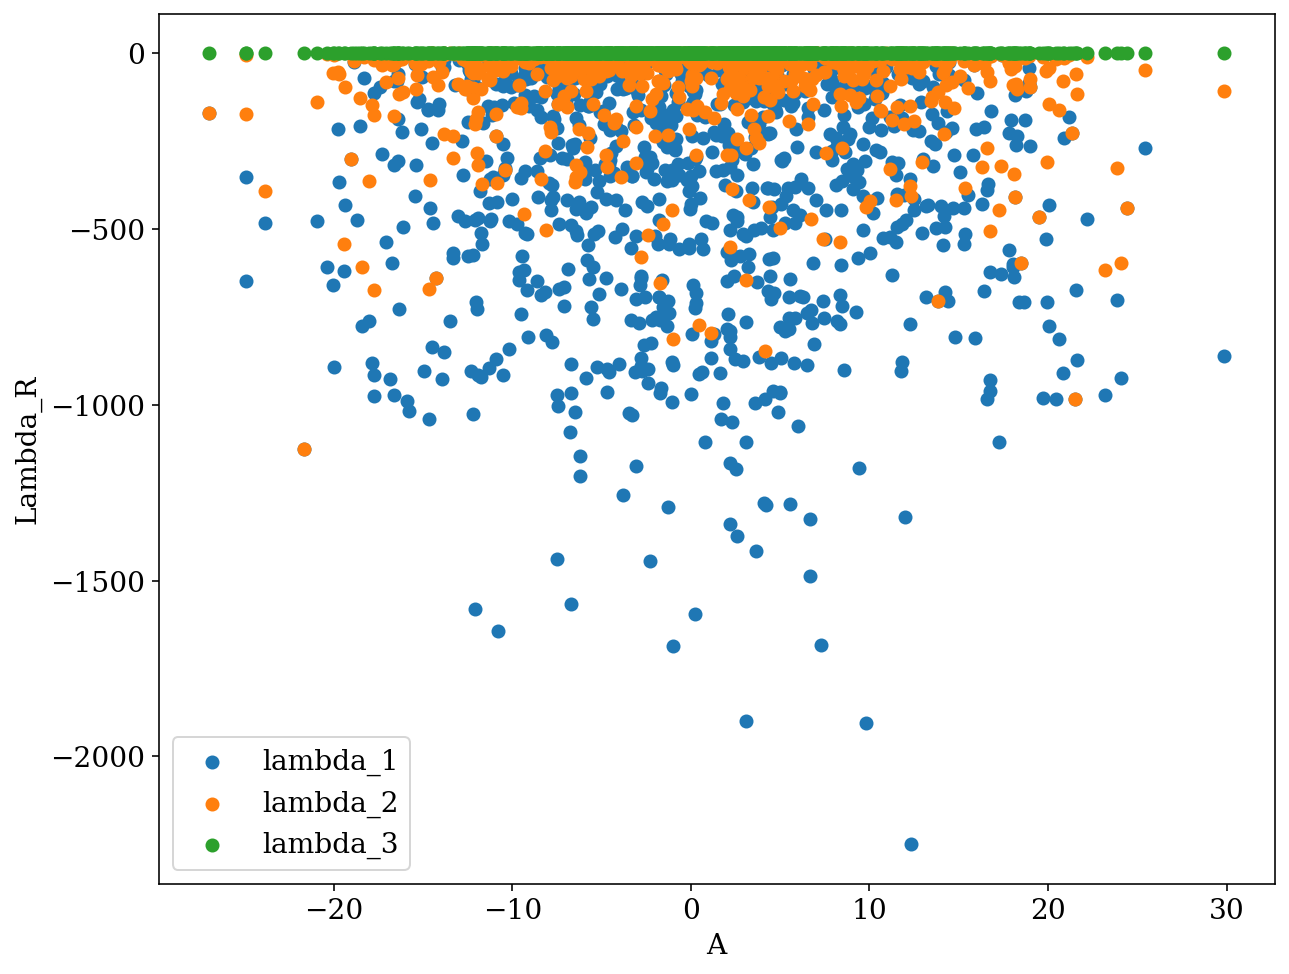

In [22]:
plt.scatter(all_affinities, all_eigvals_real[:,0], label='lambda_1')
plt.scatter(all_affinities, all_eigvals_real[:,1], label='lambda_2')
plt.scatter(all_affinities, all_eigvals_real[:,2], label='lambda_3')
plt.xlabel('A')
plt.ylabel('Lambda_R')
plt.legend()

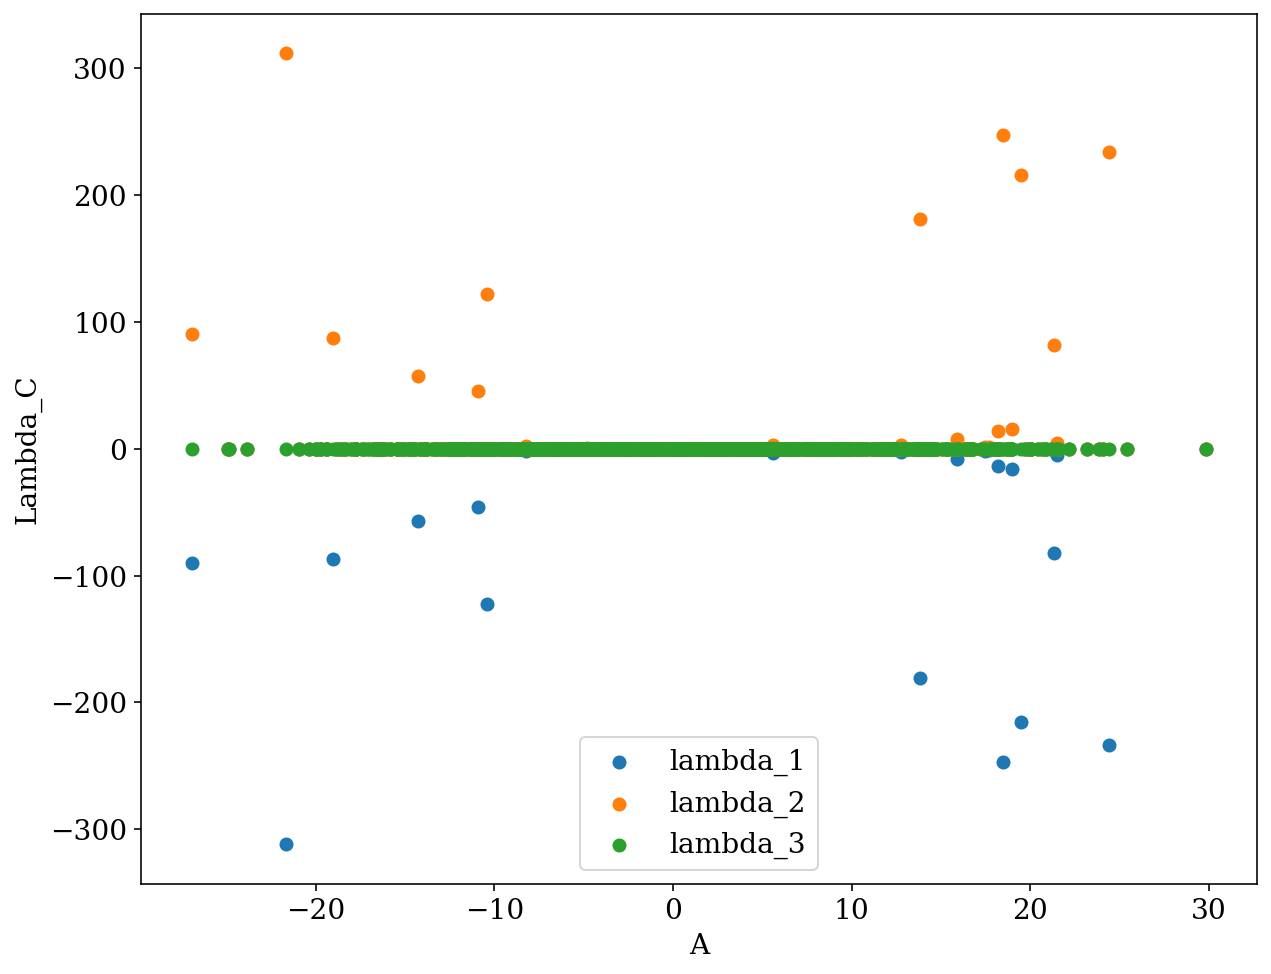

In [23]:
plt.scatter(all_affinities, all_eigvals_complex[:,0], label='lambda_1')
plt.scatter(all_affinities, all_eigvals_complex[:,1], label='lambda_2')
plt.scatter(all_affinities, all_eigvals_complex[:,2], label='lambda_3')
plt.xlabel('A')
plt.ylabel('Lambda_C')
plt.legend()

Find a parameter set that has complex eigenvalues and a particular affinity.

In [24]:
indices = np.nonzero(all_eigvals_complex)

In [25]:
all_affinities[indices[0][0]]

array([18.9844336])

In [26]:
all_eigvals_complex[indices[0][0]]

array([-15.83575843,  15.83575843,   0.        ])

In [27]:
all_labels[indices[0][0],:]

array([3.5470000e-02, 4.0306350e+01, 1.1968246e+02, 8.1074900e+00,
       2.1579710e+01, 2.0600000e-03])

In [28]:
label_dict # just to see the order of rates

{(1, 3): 381.16006,
 (1, 2): 14.04793,
 (2, 3): 35.46007,
 (2, 1): 27.76811,
 (3, 1): 0.00494,
 (3, 2): 0.58598}

## Oscillations on 5-state graph

The maximal number of oscillations on the 3-vertex graph is less than one. Let's see what happens when we go up to a 5-vertex graph.

In [29]:
k12,k21,k23,k32,k34,k43,k45,k54,k15,k51 = 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

In [30]:
def affinity5(k12,k21,k23,k32,k34,k43,k45,k54,k15,k51):
    aff = np.log((k12*k23*k34*k45*k51)/(k15*k54*k43*k32*k21))
    return aff

In [31]:
# Transition rate matrix W
def transition_matrix5(k12,k21,k23,k32,k34,k43,k45,k54,k15,k51):
    W = np.array([
        [-k12-k15,k21,0,0,k51],  # Transition rates from E1
        [k12,-k21-k23,k32,0,0],  # Transition rates from E2
        [0,k23,-k32-k34,k43,0],  # Transition rates from E3
        [0,0,k34,-k43-k45,k54],  # Transition rates from E4
        [k15,0,0,k45,-k51-k54],  # Transition rates from E5
    ])
    return W

In [32]:
# Function to compute the correlation function C(t)
def correlation_function5(t, W):
    exp_Wt = expm(W * t) # Compute the matrix exponential e^(Wt)
    p = [1,0,0,0,0]
    return (exp_Wt[0]*p)[0] # e^(Wt)[11] Prob of being in 1 at time t given was in 1 at time 0

In [33]:
# Oscillatory transition rates

k12, k23, k34, k45, k51 = 0.0, 0.0, 0.0, 0.0, 0.0
k21, k32, k43, k54, k15 = 2.0, 2.0, 2.0, 2.0, 2.0

#k12, k15, k21, k23, k32, k34, k43, k45, k54, k51 = 6.6867835e+02, 1.2356196e+02, 3.0750714e+02, 4.6800000e-03, 1.0429112e+02, 1.2768300e+01, 1.0017890e+01, 3.5640000e-01, 5.3848260e+01, 1.6982000e-01

# force
#print("force: " + str(affinity5(k12,k21,k23,k32,k34,k43,k45,k54,k15,k51)))

# eigenvalues of W
W = transition_matrix5(k12,k21,k23,k32,k34,k43,k45,k54,k15,k51)
eigvals, eigvecs = scipy.linalg.eig(W)
print("eigenvalues: " + str(eigvals))

x_i = np.abs(np.sort(eigvals)[-2].imag)
x_r = np.abs(np.sort(eigvals)[-2].real)

# decay time
tau = 1/x_r
print("decay time: " + str(tau))

# oscillation period
omega = (2*math.pi)/x_i
print("period: " + str(omega))

# number of coherent oscillations
R = x_i/x_r
print("number coherent oscillations: " + str(R/2*math.pi))

# Time points for the plot
times = np.linspace(0, 10, 500)  # time from 0 to 4 with 500 points
# Compute C(t) for each time point
correlation_values = [correlation_function5(t, W) for t in times]

eigenvalues: [-3.61803399e+00+1.1755705j  -3.61803399e+00-1.1755705j
 -1.38196601e+00+1.90211303j -1.38196601e+00-1.90211303j
 -3.05992170e-16+0.j        ]
decay time: 0.7236067977499785
period: 3.303265999194125
number coherent oscillations: 2.1620156649430227


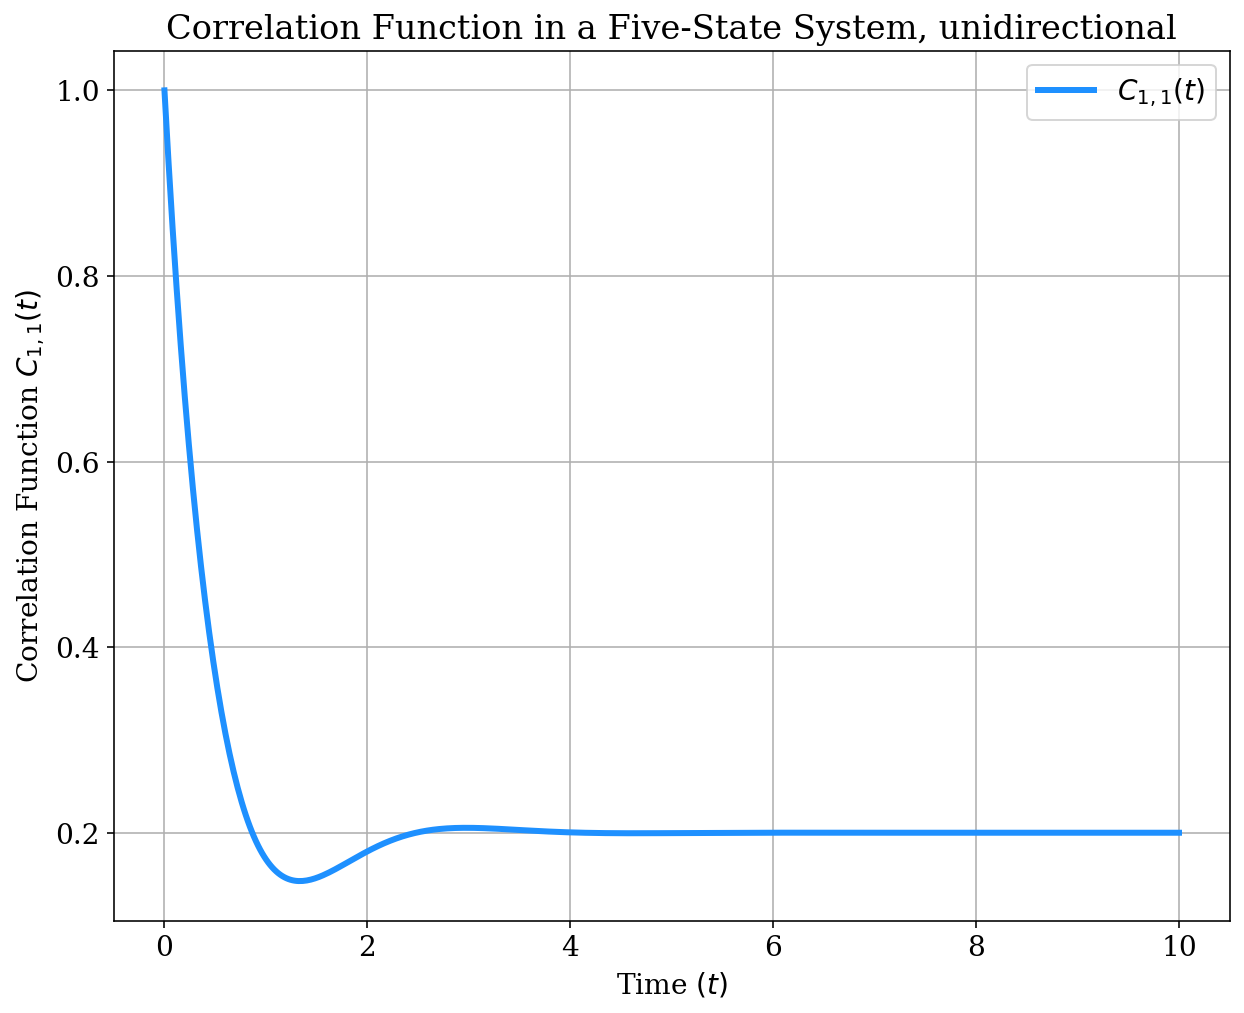

In [34]:
plt.plot(times, correlation_values, label=r'$C_{1,1}(t)$', linewidth=3, color='dodgerblue')
plt.xlabel(r'Time $(t)$')
plt.ylabel(r'Correlation Function $C_{1,1}(t)$')
plt.title(r'Correlation Function in a Five-State System, unidirectional')
plt.legend()
plt.grid()
plt.show()

## Sampling parameters for 5-vertex graph that have complex eigenvalues 

What parameter sets give you complex eigenvalues?

In [35]:
G = nx.DiGraph()
G_size = 5
nodes = np.arange(1,G_size+1,step=1)
G.add_nodes_from(nodes)

G.add_edge(1,2)
G.add_edge(2,1)
G.add_edge(2,3)
G.add_edge(3,2)
G.add_edge(4,3)
G.add_edge(3,4)
G.add_edge(4,5)
G.add_edge(5,4)
G.add_edge(5,1)
G.add_edge(1,5)

G_ud = nx.Graph()
G_ud.add_node(1)
G_ud.add_node(2)
G_ud.add_node(3)
G_ud.add_edge(3, 2)
G_ud.add_edge(2, 3)
G_ud.add_edge(1, 2)
G_ud.add_edge(2, 1)
G_ud.add_edge(4,3)
G_ud.add_edge(3,4)
G_ud.add_edge(4,5)
G_ud.add_edge(5,4)
G_ud.add_edge(5,1)
G_ud.add_edge(1,5)

In [36]:
node_list = get_nodes(G)
num_nodes = G_size
edge_list = get_edges(G)

# not needed for 3-cycle graph but we need the data structures
cycle_list = get_cycles(G_ud)
num_cycles = len(cycle_list)

In [37]:
label_dict, label_list = get_labels(G)

In [38]:
label_dict

{(1, 2): 16.92244,
 (1, 5): 0.06637,
 (2, 1): 55.45385,
 (2, 3): 0.61538,
 (3, 2): 250.19028,
 (3, 4): 206.89946,
 (4, 3): 2.55835,
 (4, 5): 0.00559,
 (5, 4): 0.06177,
 (5, 1): 0.00981}

In [39]:
all_labels = np.zeros((10,10))
all_eigvals_real = np.zeros((10,5))
all_eigvals_complex = np.zeros((10,5))
all_affinities = np.zeros((10))

In [40]:
for i in range(10):
    label_dict, label_list = get_labels(G)
    all_labels[i] = label_list
    cycle_edges_forward,cycle_edges_backward,cycle_labels_forward,cycle_labels_backward = get_cycle_labels_edges(cycle_list,label_dict)
    products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)
    total_affinities = calculate_affinities(products_f, products_b, cycle_list)
    all_affinities[i] = total_affinities
    L = Laplacian_all(edge_list,label_list,node_list)
    eigvals, eigvecs = scipy.linalg.eig(L)
    eigvals_sorted = np.sort(eigvals)
    all_eigvals_real[i] = eigvals_sorted.real
    all_eigvals_complex[i] = eigvals_sorted.imag

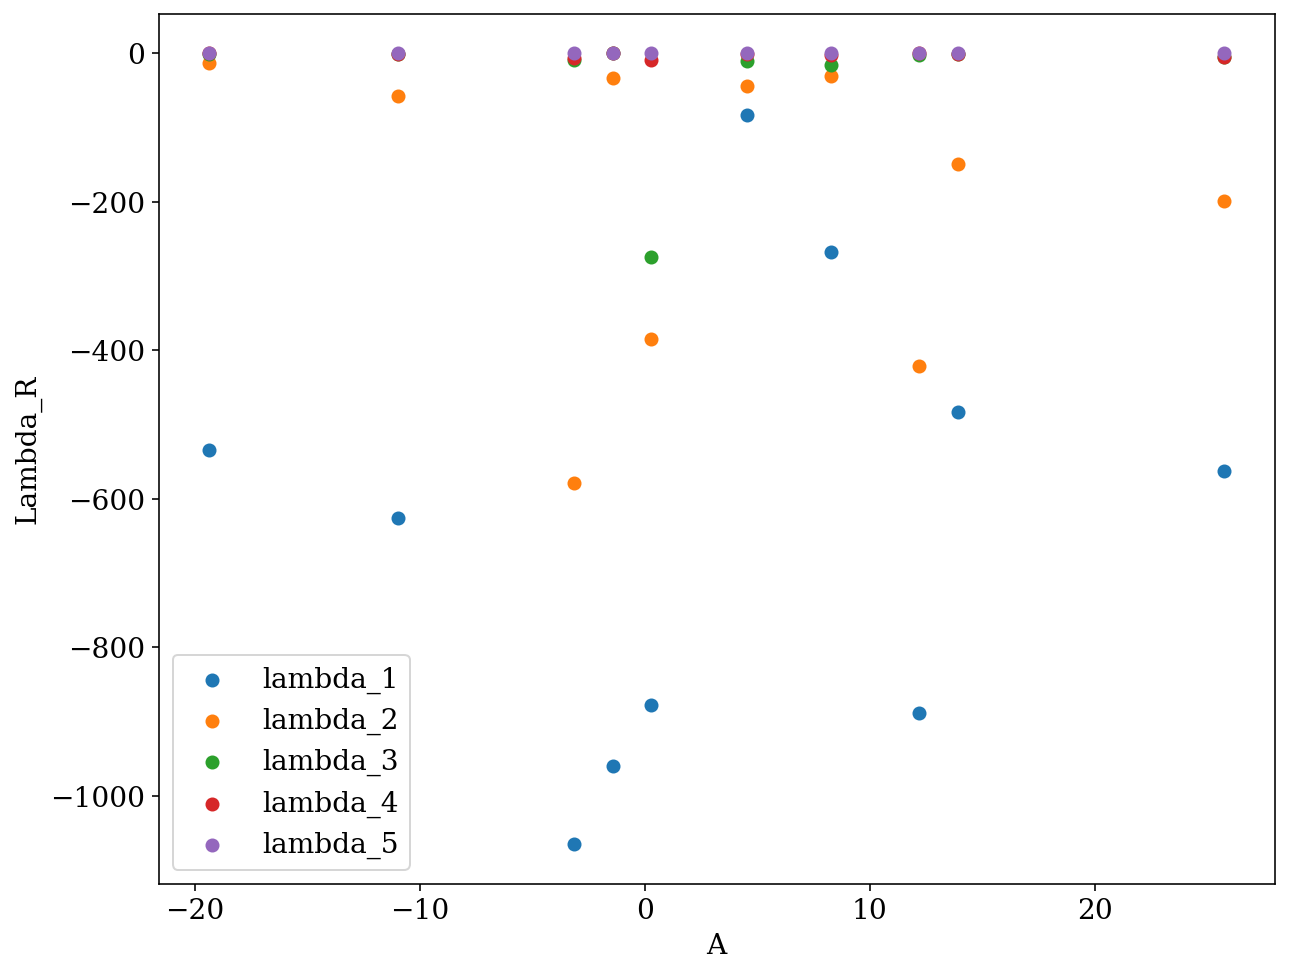

In [41]:
plt.scatter(all_affinities, all_eigvals_real[:,0], label='lambda_1')
plt.scatter(all_affinities, all_eigvals_real[:,1], label='lambda_2')
plt.scatter(all_affinities, all_eigvals_real[:,2], label='lambda_3')
plt.scatter(all_affinities, all_eigvals_real[:,3], label='lambda_4')
plt.scatter(all_affinities, all_eigvals_real[:,4], label='lambda_5')
plt.xlabel('A')
plt.ylabel('Lambda_R')
plt.legend()

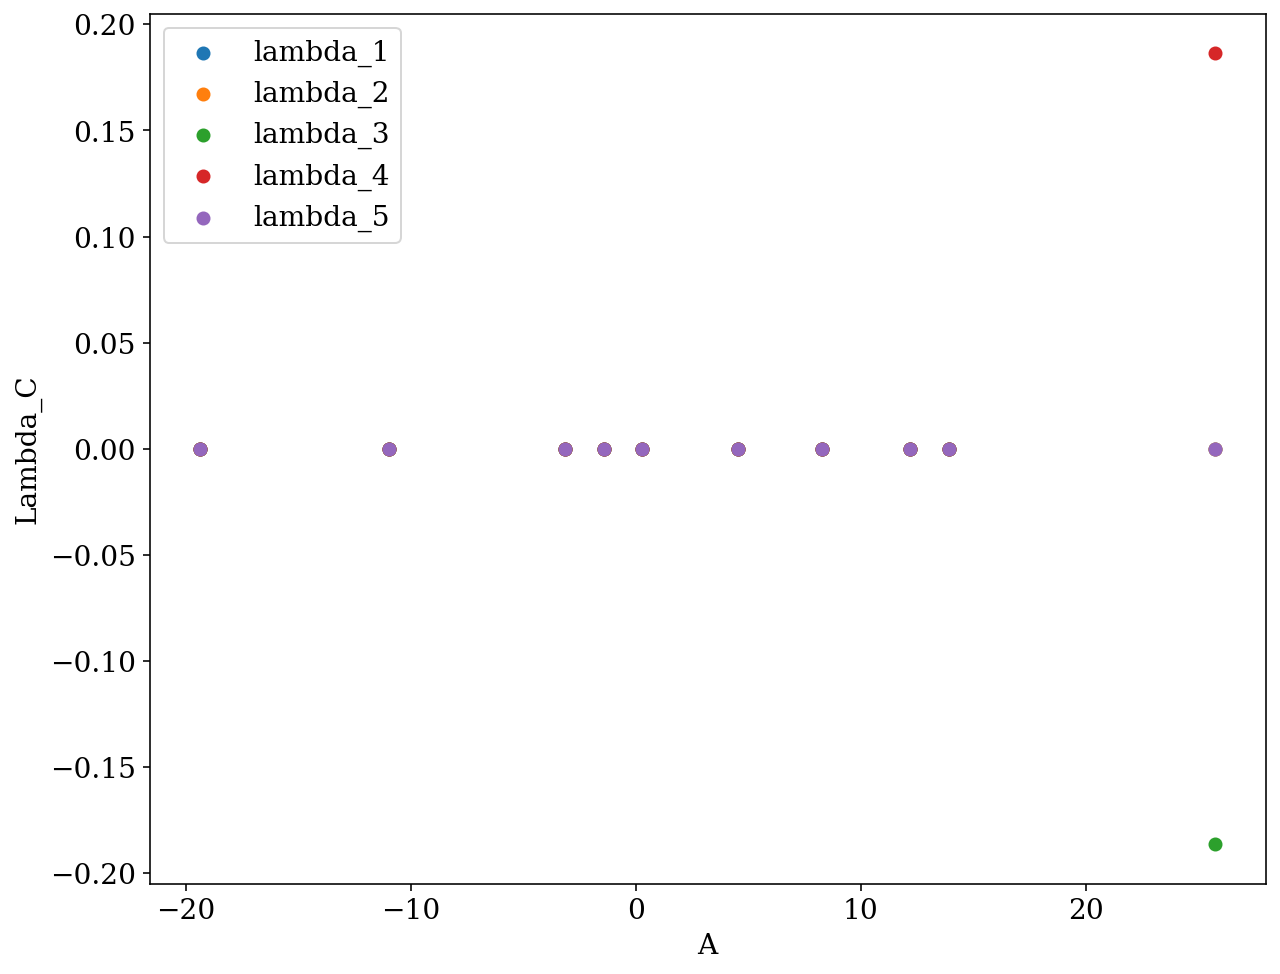

In [42]:
plt.scatter(all_affinities, all_eigvals_complex[:,0], label='lambda_1')
plt.scatter(all_affinities, all_eigvals_complex[:,1], label='lambda_2')
plt.scatter(all_affinities, all_eigvals_complex[:,2], label='lambda_3')
plt.scatter(all_affinities, all_eigvals_complex[:,3], label='lambda_4')
plt.scatter(all_affinities, all_eigvals_complex[:,4], label='lambda_5')
plt.xlabel('A')
plt.ylabel('Lambda_C')
plt.legend()

In [43]:
indices = np.nonzero(all_eigvals_complex)

In [44]:
all_affinities[indices[0][0]]

25.73411517434478

In [45]:
all_eigvals_complex[indices[0][0]]

array([ 0.        ,  0.        , -0.18632332,  0.18632332,  0.        ])

In [46]:
all_labels[indices[0][0],:]

array([3.4967000e+00, 9.6500000e-03, 2.1313000e-01, 5.4988900e+00,
       2.2700000e-03, 3.0206550e+01, 1.3400000e-03, 4.2889200e+00,
       5.2872932e+02, 1.9922218e+02])

In [47]:
label_dict # just to see the order of rates

{(1, 2): 190.94784,
 (1, 5): 7.79406,
 (2, 1): 873.48173,
 (2, 3): 4.58762,
 (3, 2): 2.51031,
 (3, 4): 483.06873,
 (4, 3): 0.4788,
 (4, 5): 0.7714,
 (5, 4): 95.55074,
 (5, 1): 0.10531}

## Oscillations on N-vertex unicyclic graph

Now that we see that a 5-vertex graph doesn't produce many more oscillations, we can develop a more general workflow to produce the correlation function plot for a unicyclic network with $N$ states and fixed affinity $\mathcal{A}$. We want to see for what value of $N$ do we start to see visibly coherent oscillations.

In [8]:
def unicycle_graph(n):
    """
    Generates a reversible unicyclic linear framework graph of size n.
    
    Parameters
    ----------
    n : integer
        the size (or number of vertices) of the graph
    
    Returns
    -------
    G : NetworkX DiGraph object
        directed graph
    
    G_ud : NetworkX Graph object
        undirected graph
    """
    
    G = nx.DiGraph()
    G_ud = nx.Graph()
    
    # determine the number of nodes in G
    G_size = n
    
    # add nodes to G and G_ud
    nodes = np.arange(1,G_size+1,step=1)
    G.add_nodes_from(nodes)
    G_ud.add_nodes_from(nodes)
    
    for i in range(2,G_size+1):
        u = i-1
        v = i
        G.add_edge(u,v)
        G.add_edge(v,u)
        G_ud.add_edge(u,v)
        
    G.add_edge(G_size,1)
    G.add_edge(1,G_size)
    G_ud.add_edge(1,G_size)
    
    return G, G_ud

In [14]:
G_size = 10
G, G_ud = unicycle_graph(G_size)

In [15]:
nodes = list(G.nodes())

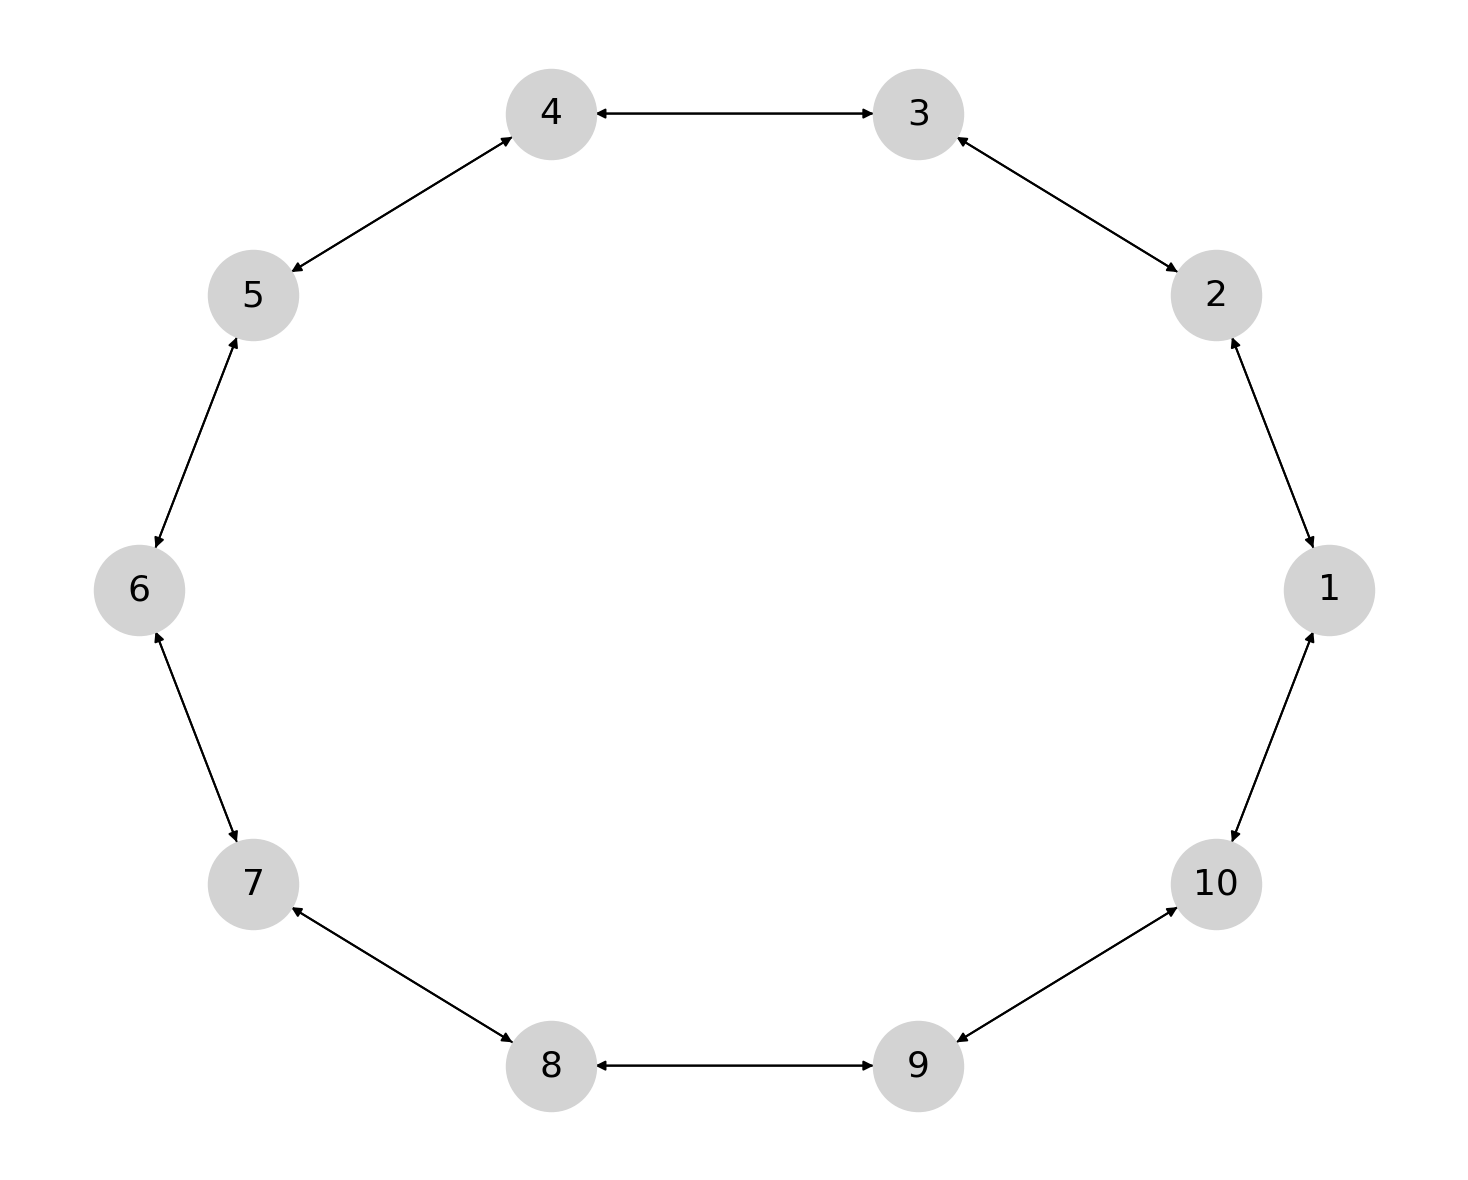

In [16]:
node_labels = {}

for node in nodes:
    node_labels[node] = str(node)

nx.draw(G, pos=nx.circular_layout(G), labels=node_labels, with_labels=True,node_size=2000, node_color = 'lightgray', font_size=18, font_color='black', font_family='sans-serif')

In [17]:
node_list = get_nodes(G)
num_nodes = G_size
edge_list = get_edges(G)

# not needed for 3-cycle graph but we need the data structures
cycle_list = get_cycles(G_ud)
num_cycles = len(cycle_list)

In [18]:
cycle_list

[[2, 3, 4, 5, 6, 7, 8, 9, 10, 1]]

In [19]:
np.array(G.edges)

array([[ 1,  2],
       [ 1, 10],
       [ 2,  1],
       [ 2,  3],
       [ 3,  2],
       [ 3,  4],
       [ 4,  3],
       [ 4,  5],
       [ 5,  4],
       [ 5,  6],
       [ 6,  5],
       [ 6,  7],
       [ 7,  6],
       [ 7,  8],
       [ 8,  7],
       [ 8,  9],
       [ 9,  8],
       [ 9, 10],
       [10,  9],
       [10,  1]])

In [20]:
edge_tracker = []
edge_labels_forward = np.array([])
edge_labels_backward = np.array([])

for i in range(num_nodes-1):
    u = cycle_list[0][i]
    v = cycle_list[0][i+1]
    
    G[u][v]['weight'] = 7.0
    edge_labels_forward = np.append(edge_labels_forward, 2.0)
    
    G[v][u]['weight'] = 1.0
    edge_labels_backward = np.append(edge_labels_backward, 1.0)

G[cycle_list[0][-1]][cycle_list[0][0]]['weight'] = 2.0
edge_labels_forward = np.append(edge_labels_forward, 2.0)
G[cycle_list[0][0]][cycle_list[0][-1]]['weight'] = 1.0
edge_labels_backward = np.append(edge_labels_backward, 1.0)

In [21]:
label_dict = {e: G[e[0]][e[1]]['weight'] for e in G.edges}
label_dict

{(1, 2): 2.0,
 (1, 10): 1.0,
 (2, 1): 1.0,
 (2, 3): 7.0,
 (3, 2): 1.0,
 (3, 4): 7.0,
 (4, 3): 1.0,
 (4, 5): 7.0,
 (5, 4): 1.0,
 (5, 6): 7.0,
 (6, 5): 1.0,
 (6, 7): 7.0,
 (7, 6): 1.0,
 (7, 8): 7.0,
 (8, 7): 1.0,
 (8, 9): 7.0,
 (9, 8): 1.0,
 (9, 10): 7.0,
 (10, 9): 1.0,
 (10, 1): 7.0}

In [22]:
label_list = np.fromiter(label_dict.values(), dtype=float)

In [23]:
W = Laplacian_all(edge_list,label_list,node_list)
W

array([[-8.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 1., -3.,  7.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1., -8.,  7.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -8.,  7.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1., -8.,  7.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1., -8.,  7.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -8.,  7.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -8.,  7.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -8.,  7.],
       [ 7.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -8.]], dtype=float128)

In [24]:
affinity = np.log(np.prod(edge_labels_forward)/np.prod(edge_labels_backward))
affinity

6.931471805599453

In [9]:
# Function to compute the correlation function C(t)
def correlation_function_general(t, W, n):
    exp_Wt = expm(W * t) # Compute the matrix exponential e^(Wt)
    #p = np.zeros((1,n))
    #p[0] = 1
    #return (exp_Wt[0]*p)[0] # e^(Wt)[11] Prob of being in 1 at time t given was in 1 at time 0
    return exp_Wt[0][0]

In [138]:
# eigenvalues of W
W = Laplacian_all(edge_list,label_list,node_list)
eigvals, eigvecs = scipy.linalg.eig(W)

x_i = np.abs(np.sort(eigvals)[-2].imag)
x_r = np.abs(np.sort(eigvals)[-2].real)

print(x_i, x_r)

# decay time
tau = 1/x_r
print("decay time: " + str(tau))

# oscillation period
omega = (2*math.pi)/x_i
print("period: " + str(omega))

# number of coherent oscillations
R = x_i/x_r
print("number coherent oscillations: " + str(R/2*math.pi))

# Time points for the plot
times = np.linspace(0, 20, 500)  # time from 0 to 1.5 with 500 points
# Compute C(t) for each time point
correlation_values = [correlation_function_general(t, W, n=100) for t in times]

2.8441498423072225 1.5308792749053501
decay time: 0.6532193729396638
period: 2.2091611397248183
number coherent oscillations: 2.9183098879084945


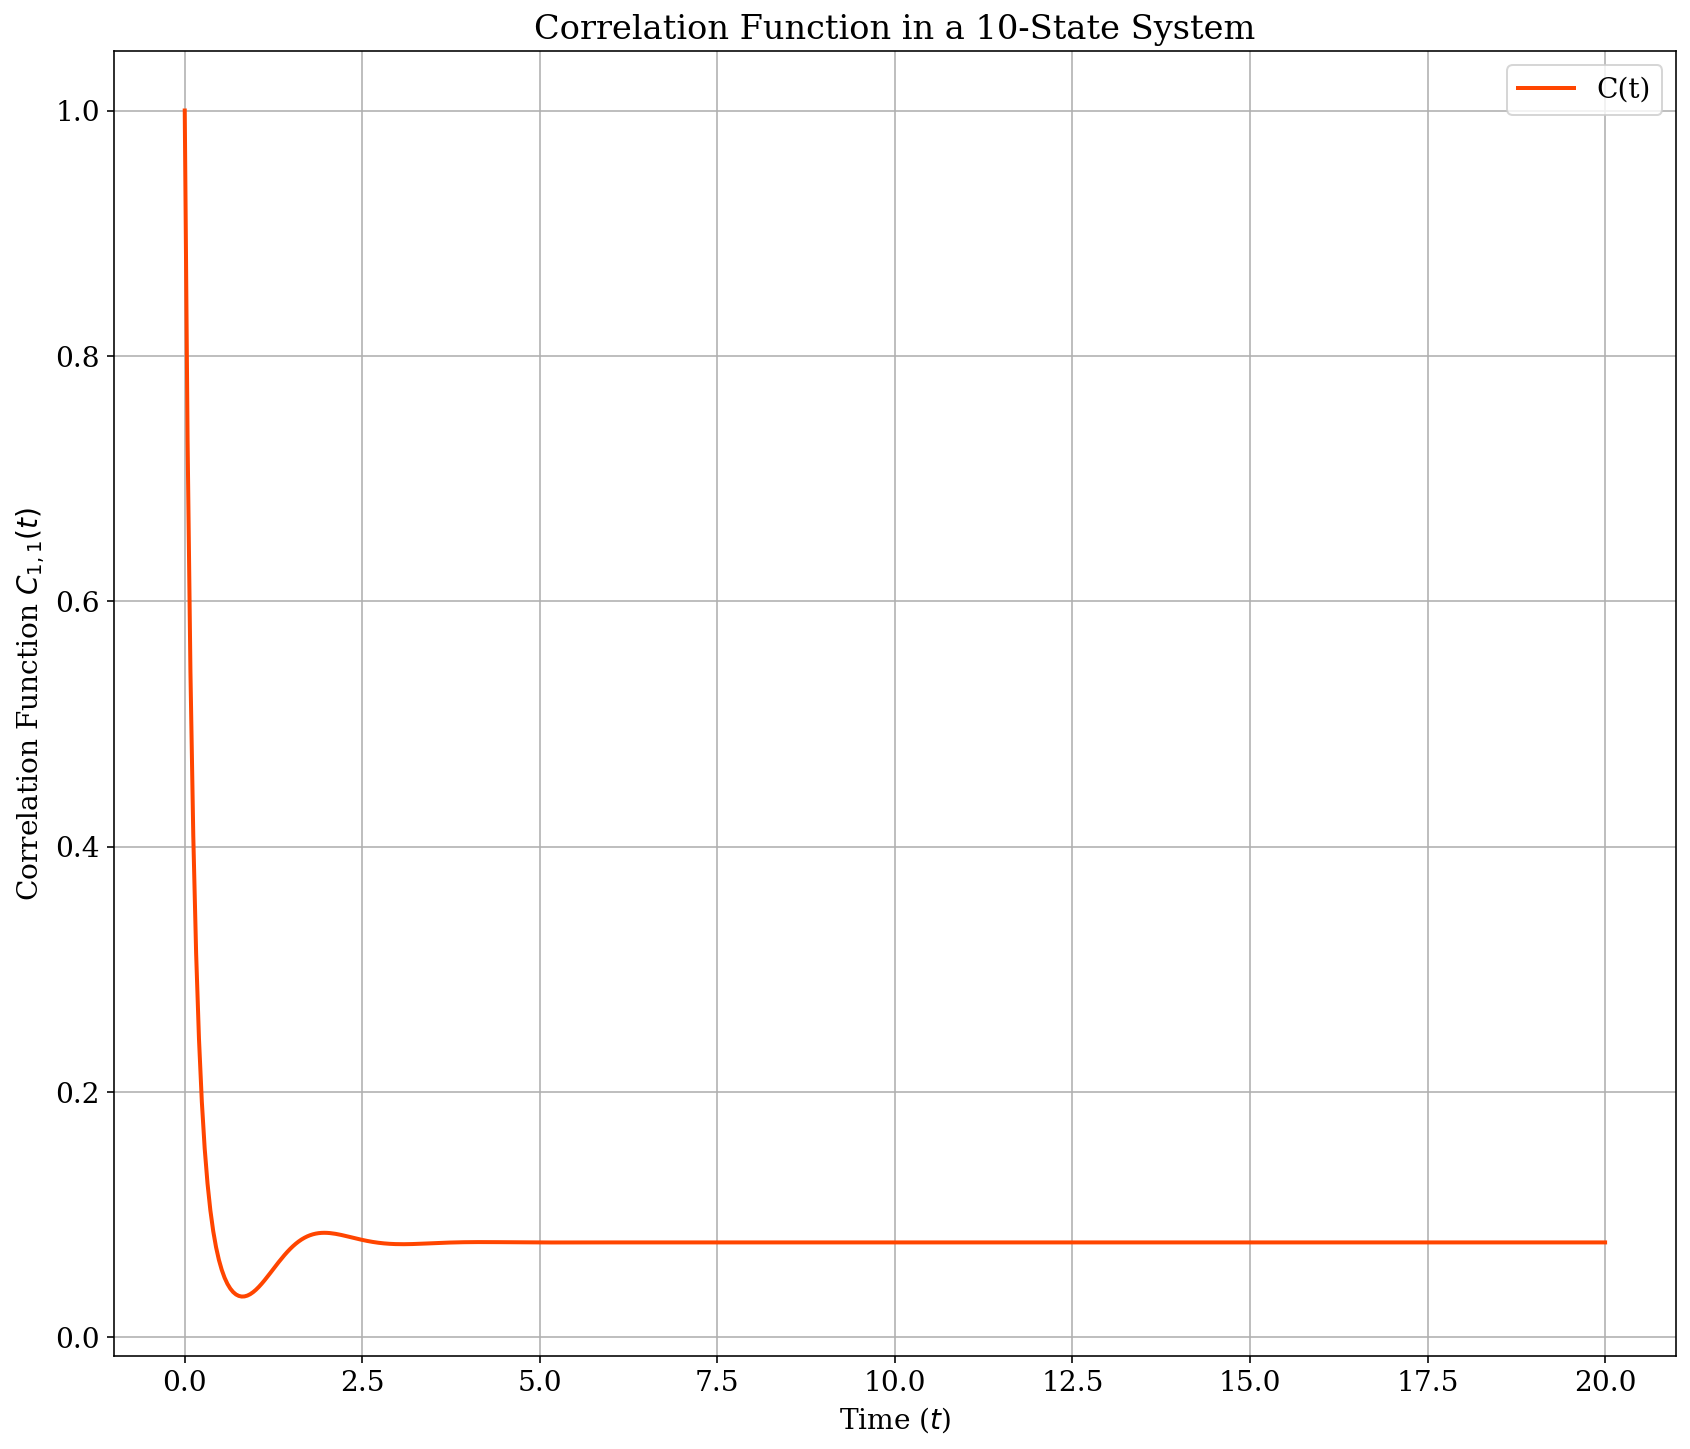

In [139]:
fig, ax = plt.subplots(figsize = (14, 12))
plt.plot(times, correlation_values, color = "orangered", linewidth=2, label='C(t)')
plt.xlabel(r'Time ($t$)')
plt.ylabel(r'Correlation Function $C_{1,1}(t)$')
plt.title('Correlation Function in a 10-State System')
plt.legend()
plt.grid()
plt.show()

Some quality checks for the code

In [145]:
p = np.zeros((1,10))
p[0] = 1

In [146]:
for i in range(num_nodes-1):
    print(cycle_list[0][i], cycle_list[0][i+1])
print(cycle_list[0][-1], cycle_list[0][0])

2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 1
1 2


## Recreating the plot from Barato & Seifert 2017

$N = 100$, $\mathcal{A} = 200$. All rates uniform, with all reverse rates set to $1.0$.

In [10]:
G, G_ud = unicycle_graph(100)

In [11]:
node_list = get_nodes(G)
num_nodes = len(node_list)
edge_list = get_edges(G)

cycle_list = get_cycles(G_ud)
num_cycles = len(cycle_list)

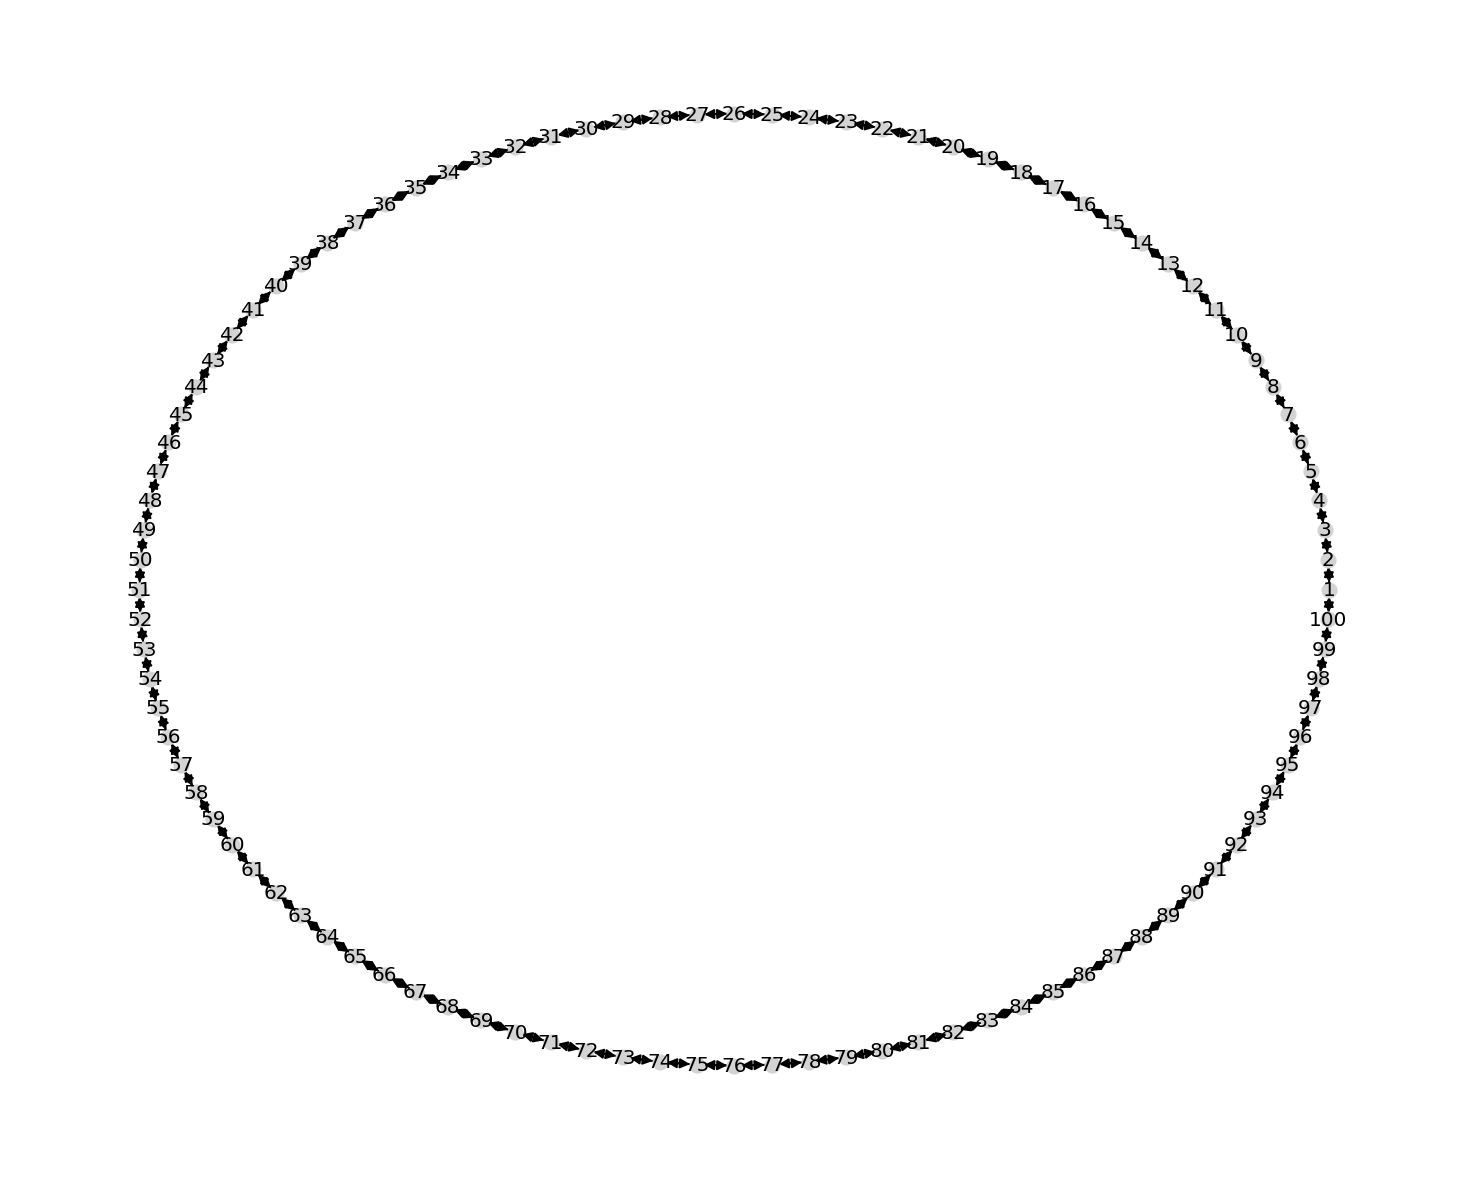

In [12]:
node_labels = {}

for node in node_list:
    node_labels[node] = str(node)

nx.draw(G, pos=nx.circular_layout(G), labels=node_labels, with_labels=True,node_size=50, node_color = 'lightgray', font_size=10, font_color='black', font_family='sans-serif')

In [13]:
# parameter values from Barato Seifert 2017
k_m = 1.0
A = 200
N = 100
k_p = k_m*math.exp(A/N)

In [14]:
edge_labels_forward = np.array([])
edge_labels_backward = np.array([])

for i in range(num_nodes-1):
    u = cycle_list[0][i]
    v = cycle_list[0][i+1]
    
    G[u][v]['weight'] = k_p
    edge_labels_forward = np.append(edge_labels_forward, k_p)
    
    G[v][u]['weight'] = k_m
    edge_labels_backward = np.append(edge_labels_backward, k_m)

G[cycle_list[0][-1]][cycle_list[0][0]]['weight'] = k_p
edge_labels_forward = np.append(edge_labels_forward, k_p)
G[cycle_list[0][0]][cycle_list[0][-1]]['weight'] = k_m
edge_labels_backward = np.append(edge_labels_backward, k_m)

In [15]:
label_dict = {e: G[e[0]][e[1]]['weight'] for e in G.edges}

In [16]:
label_list = np.fromiter(label_dict.values(), dtype=float)

In [17]:
W = Laplacian_all(edge_list,label_list,node_list)

In [18]:
affinity = np.log(np.prod(edge_labels_forward)/np.prod(edge_labels_backward))
affinity

200.0

In [19]:
# eigenvalues of W
W = Laplacian_all(edge_list,label_list,node_list)
eigvals, eigvecs = scipy.linalg.eig(W)

x_i = np.abs(np.sort(eigvals)[-2].imag)
x_r = np.abs(np.sort(eigvals)[-2].real)

print(x_i, x_r)

# decay time
tau = 1/x_r
print("decay time: " + str(tau))

# oscillation period
omega = (2*math.pi)/x_i
print("period: " + str(omega))

# number of coherent oscillations
R = x_i/x_r
print("number coherent oscillations: " + str(R/2*math.pi))

# Time points for the plot
times = np.linspace(100, 250, 500)  # time from 0 to 1.5 with 500 points
# Compute C(t) for each time point
correlation_values = [correlation_function_general(t, W, n=100) for t in tqdm(times)]

0.4011721517537834 0.01655778698300714
decay time: 60.39454433290367
period: 15.662067468321798
number coherent oscillations: 38.05821049841779


100%|█████████████████████████████████████████| 500/500 [10:05<00:00,  1.21s/it]


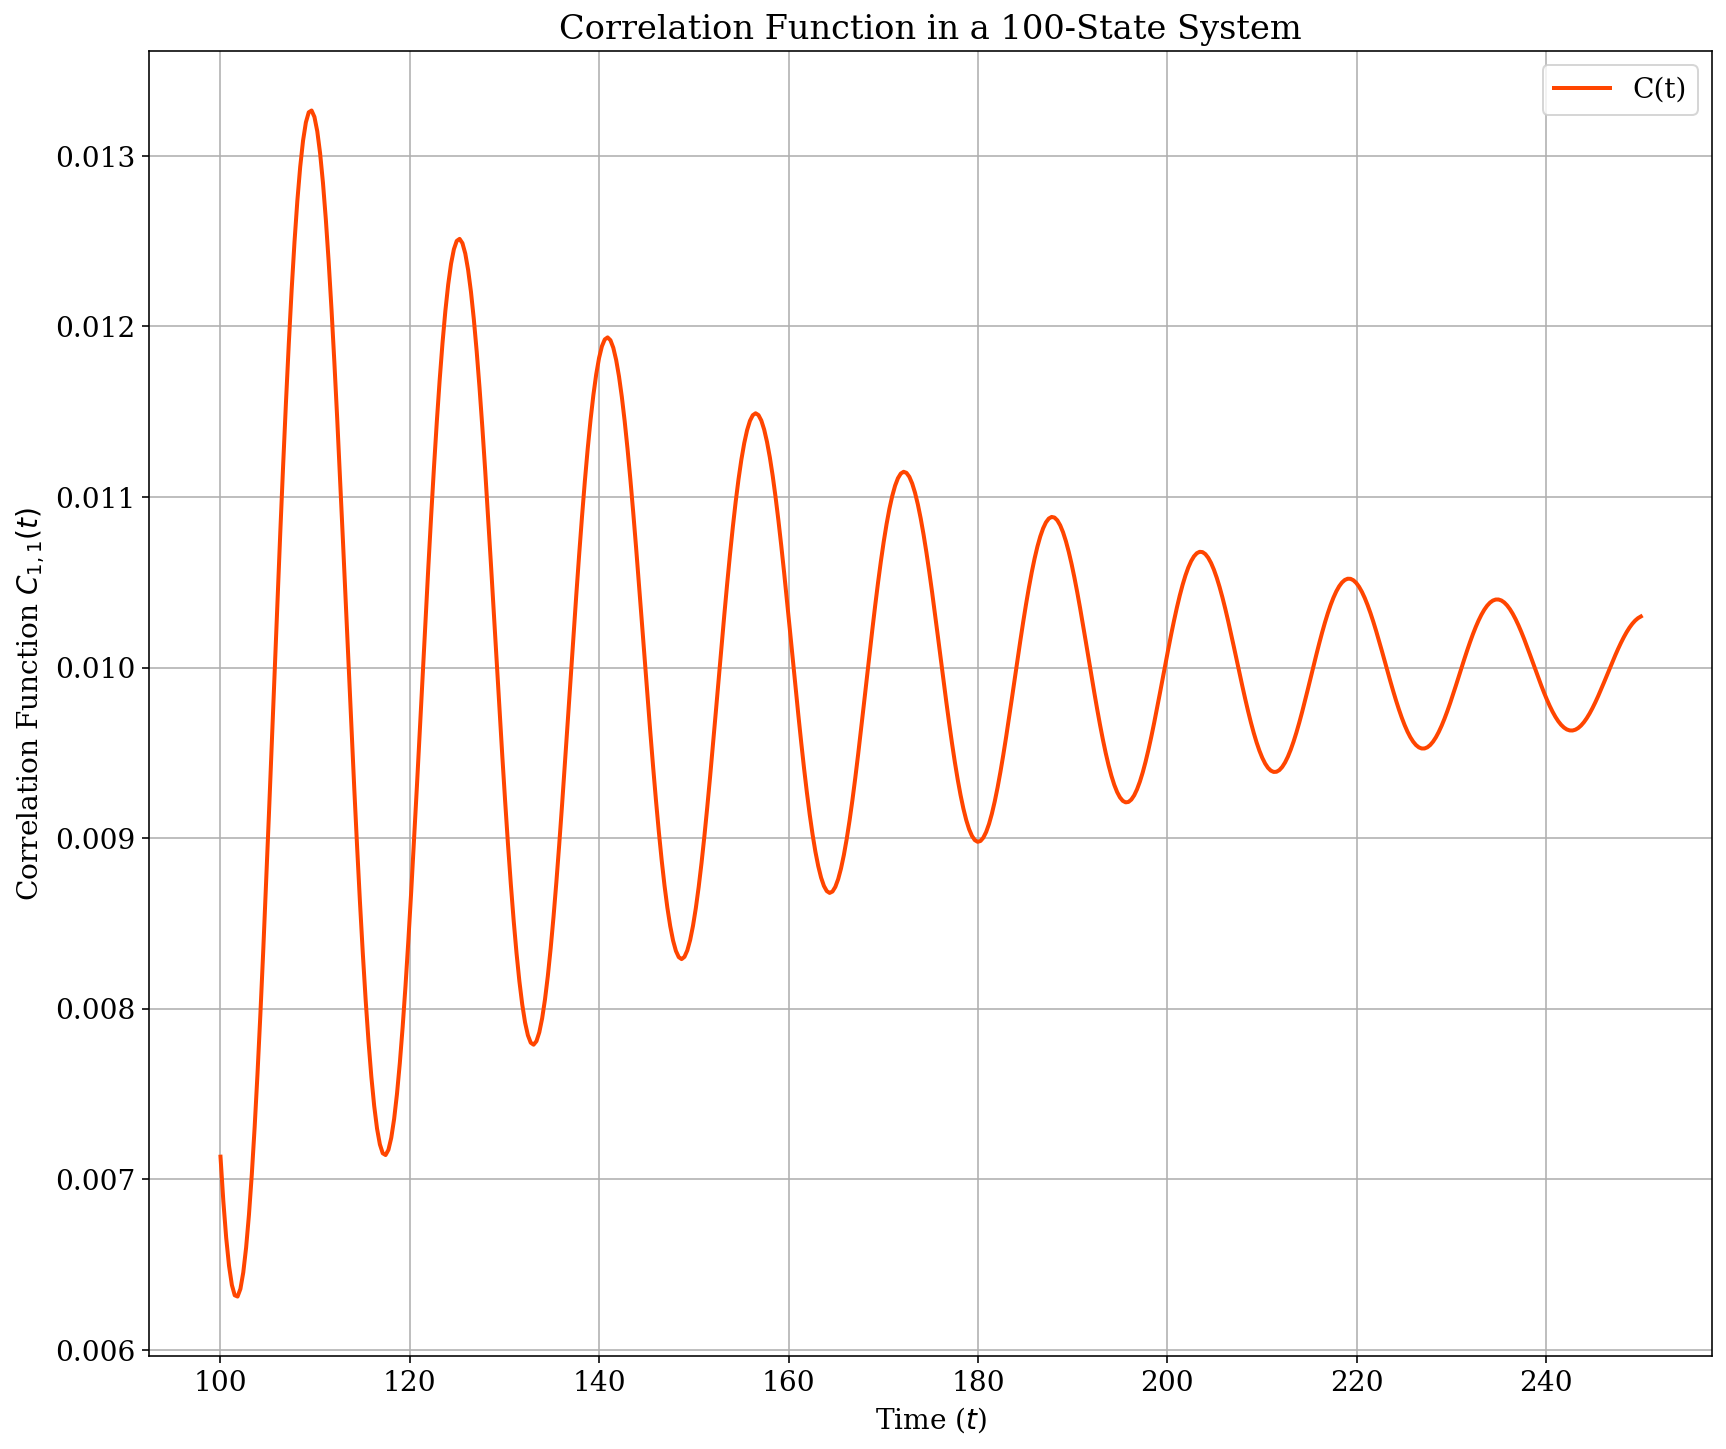

In [23]:
fig, ax = plt.subplots(figsize = (14, 12))
plt.plot(times, correlation_values, color = "orangered", linewidth=2, label='C(t)')
plt.xlabel(r'Time ($t$)')
plt.ylabel(r'Correlation Function $C_{1,1}(t)$')
plt.title('Correlation Function in a 100-State System')
plt.legend()
plt.grid()
plt.show()

## Fitting an exponential cosine function to the peaks of the oscillation function

The correlation function can be fit by a exponential cosine function of the following form.

$$C_{1,1}(t) = \exp{(-X_R|t|)}\cos{(X_I t)}$$

Note that the decay exponent of the exponential function is given by $X_R$, the real part of the first nontrivial eigenvalue, and the cosine argument contains $X_I$, the imaginary part.

These expoential cosines are fitted to the peaks of the oscillatory correlation function. It's worth noting that the first nontrivial eigenvalue sets the decay, and the second nontrivial eigenvalue sets the time on which the simple $exp*cos$ behavior emerges. The first nontrivial eigenvalue only dominates in the long time limit when all the other eigenvalues have died out (i.e. on timescales longer than $1/\lambda_2$).

So, in this part, I am trying to replicate the exponential function (the red solid line) from the Barato Seifert figure. It appears that one has to adjust the exponential function to fit the peaks of the oscillation.

In [53]:
x_i2 = np.abs(np.sort(eigvals)[-4].imag)
x_r2 = np.abs(np.sort(eigvals)[-4].real)

In [54]:
x_r2

0.06615411409902101

In [55]:
x_i2

0.8007610603027153

In [58]:
# characteristic timescales
tau = 1/x_r2
tau

15.116217844035774

This tells us that using the first nontrivial eigenvalue is the correct choice. Now we can work on creating the fitting function.

In [63]:
peaks = scipy.signal.find_peaks(correlation_values)

In [118]:
from scipy import optimize

def exp(t, A, lbda):
    r"""y(t) = A \cdot \exp(-\lambda t)"""
    return A * np.exp(-lbda * t)

def cos(t, omega, phi):
    r"""y(t) = \sin(\omega \cdot t + phi)"""
    return np.cos(omega * t)

def damped_cos(t, A, lbda, omega, phi, C):
    r"""y(t) = A \cdot \exp(-\lambda t) \cdot \left( \sin \left( \omega t + \phi ) \right)"""
    return exp(t, A, lbda) * cos(t, omega, phi) + C

def exp_true(t, A, lbda, C):
    r"""y(t) = A \cdot \exp(-\lambda t)"""
    return A * np.exp(-lbda * t) + C

t = times
lbda = x_r
omega = x_i
A = 0.02
phi = 1
C = 0.01

exp_cos_vals = damped_cos(t, A, x_r, x_i, phi, C)
exp_vals = exp_true(t, A, lbda,C)

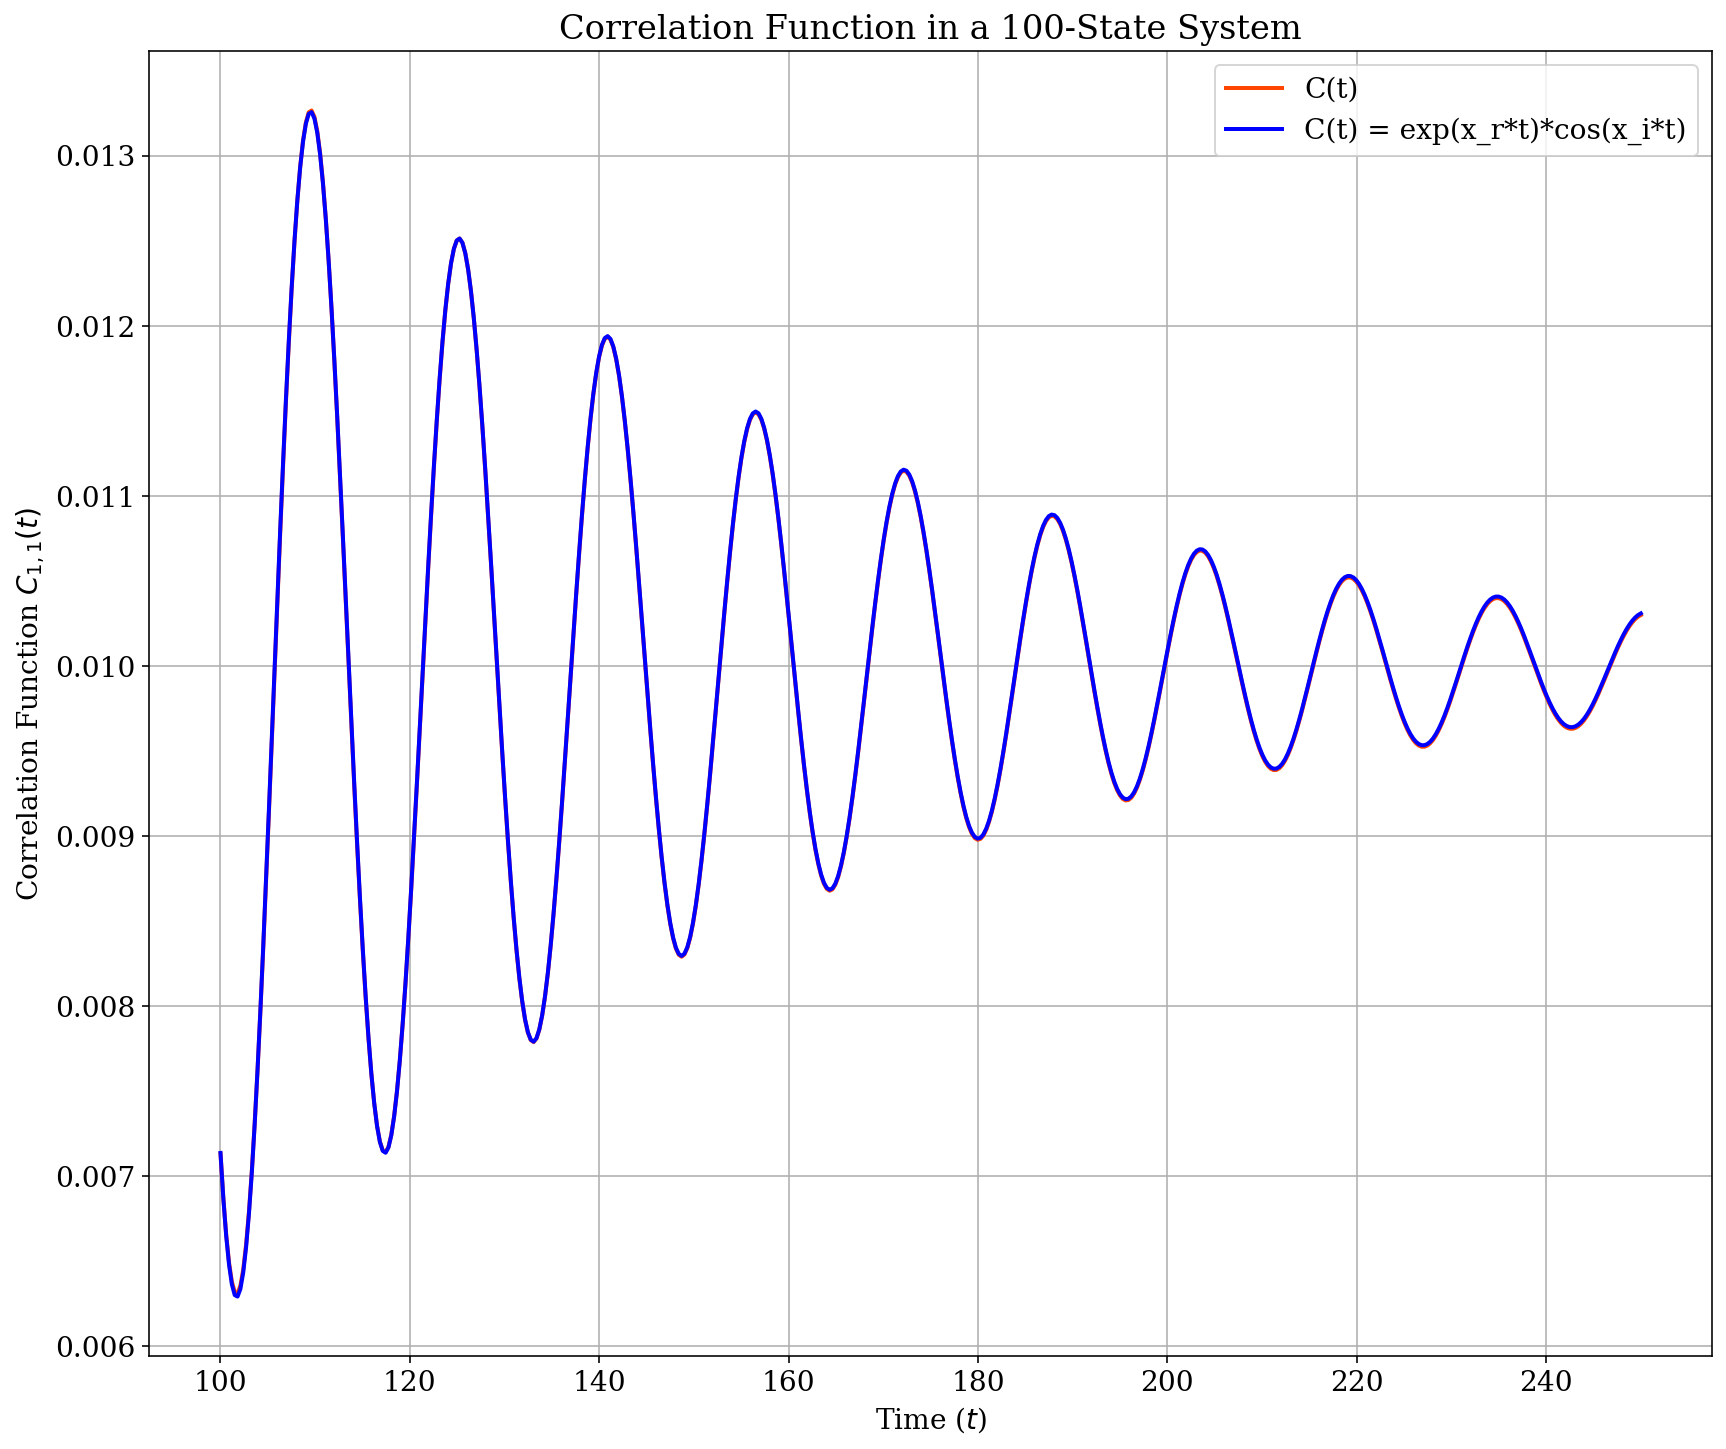

In [125]:
fig, ax = plt.subplots(figsize = (14, 12))
plt.plot(times, correlation_values, color = "orangered", linewidth=2, label='C(t)')
#plt.plot(times, exp_vals, color = "blue", linewidth=2, label='C(t)')
plt.plot(times, exp_cos_vals, color = "blue", linewidth=2, label='C(t) = exp(x_r*t)*cos(x_i*t)')
plt.xlabel(r'Time ($t$)')
plt.ylabel(r'Correlation Function $C_{1,1}(t)$')
plt.title('Correlation Function in a 100-State System')
plt.legend()
plt.grid()
plt.show()
fig.savefig('barato_seifert_100_expcosfit.png')

## What's the minimum number of states needed to get reasonable oscillations?

In [137]:
x = 40
G, G_ud = unicycle_graph(x)

In [138]:
node_list = get_nodes(G)
num_nodes = len(node_list)
edge_list = get_edges(G)

cycle_list = get_cycles(G_ud)
num_cycles = len(cycle_list)

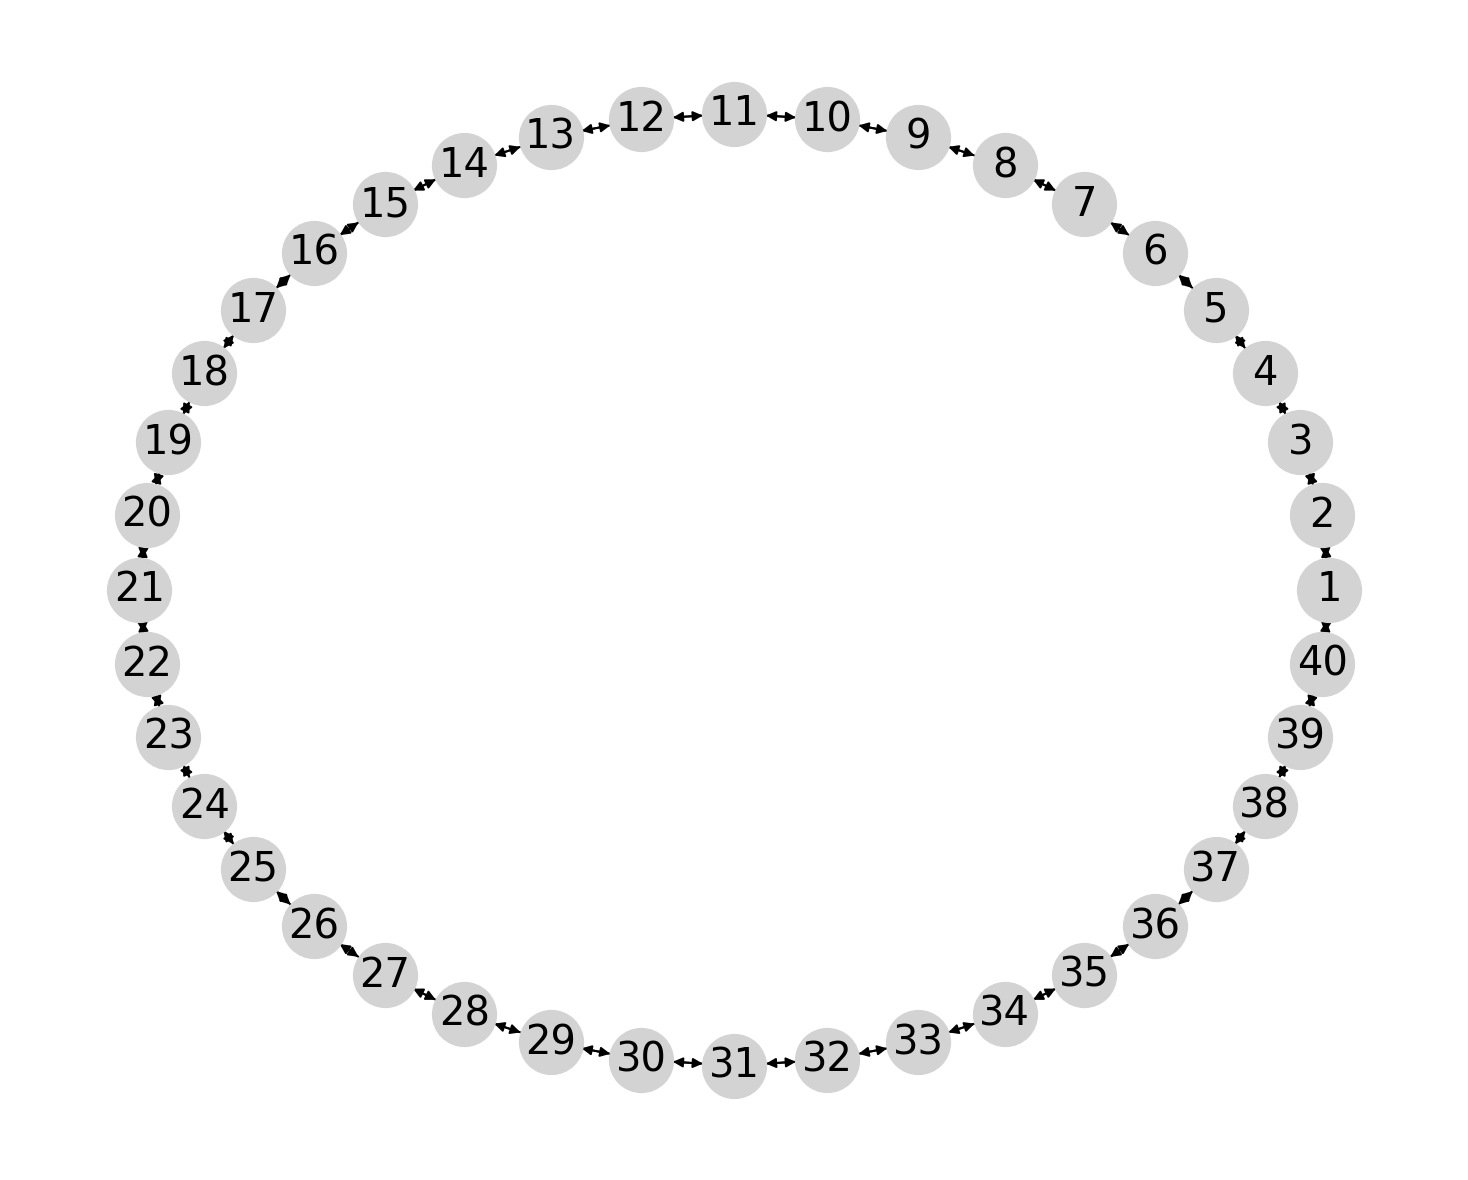

In [139]:
node_labels = {}

for node in node_list:
    node_labels[node] = str(node)

nx.draw(G, pos=nx.circular_layout(G), labels=node_labels, with_labels=True,node_size=1000, node_color = 'lightgray', font_size=20, font_color='black', font_family='sans-serif')

In [140]:
# parameter values from Barato Seifert 2017
k_m = 1.0
A = 200
N = 100
k_p = k_m*math.exp(A/N)

In [141]:
edge_labels_forward = np.array([])
edge_labels_backward = np.array([])

for i in range(num_nodes-1):
    u = cycle_list[0][i]
    v = cycle_list[0][i+1]
    
    G[u][v]['weight'] = k_p
    edge_labels_forward = np.append(edge_labels_forward, k_p)
    
    G[v][u]['weight'] = k_m
    edge_labels_backward = np.append(edge_labels_backward, k_m)

G[cycle_list[0][-1]][cycle_list[0][0]]['weight'] = k_p
edge_labels_forward = np.append(edge_labels_forward, k_p)
G[cycle_list[0][0]][cycle_list[0][-1]]['weight'] = k_m
edge_labels_backward = np.append(edge_labels_backward, k_m)

In [142]:
label_dict = {e: G[e[0]][e[1]]['weight'] for e in G.edges}

In [143]:
label_list = np.fromiter(label_dict.values(), dtype=float)

In [144]:
W = Laplacian_all(edge_list,label_list,node_list)

In [145]:
affinity = np.log(np.prod(edge_labels_forward)/np.prod(edge_labels_backward))
affinity

80.0

In [274]:
# eigenvalues of W
W = Laplacian_all(edge_list,label_list,node_list)
eigvals, eigvecs = scipy.linalg.eig(W)

x_i = np.abs(np.sort(eigvals)[-2].imag)
x_r = np.abs(np.sort(eigvals)[-2].real)

print(x_i, x_r)

# decay time
tau = 1/x_r
print("decay time: " + str(tau))

# oscillation period
omega = (2*math.pi)/x_i
print("period: " + str(omega))

# number of coherent oscillations
R = x_i/x_r
print("number coherent oscillations: " + str(R/2*math.pi))

# Time points for the plot
times = np.linspace(60, 120, 500)  # time from 0 to 1.5 with 500 points
# Compute C(t) for each time point
correlation_values = [correlation_function_general(t, W, n=100) for t in tqdm(times)]

0.9994685729482405 0.10328710248766335
decay time: 9.681750924511029
period: 6.286526137230504
number coherent oscillations: 15.199976815319708


100%|█████████████████████████████████████████| 500/500 [01:07<00:00,  7.40it/s]


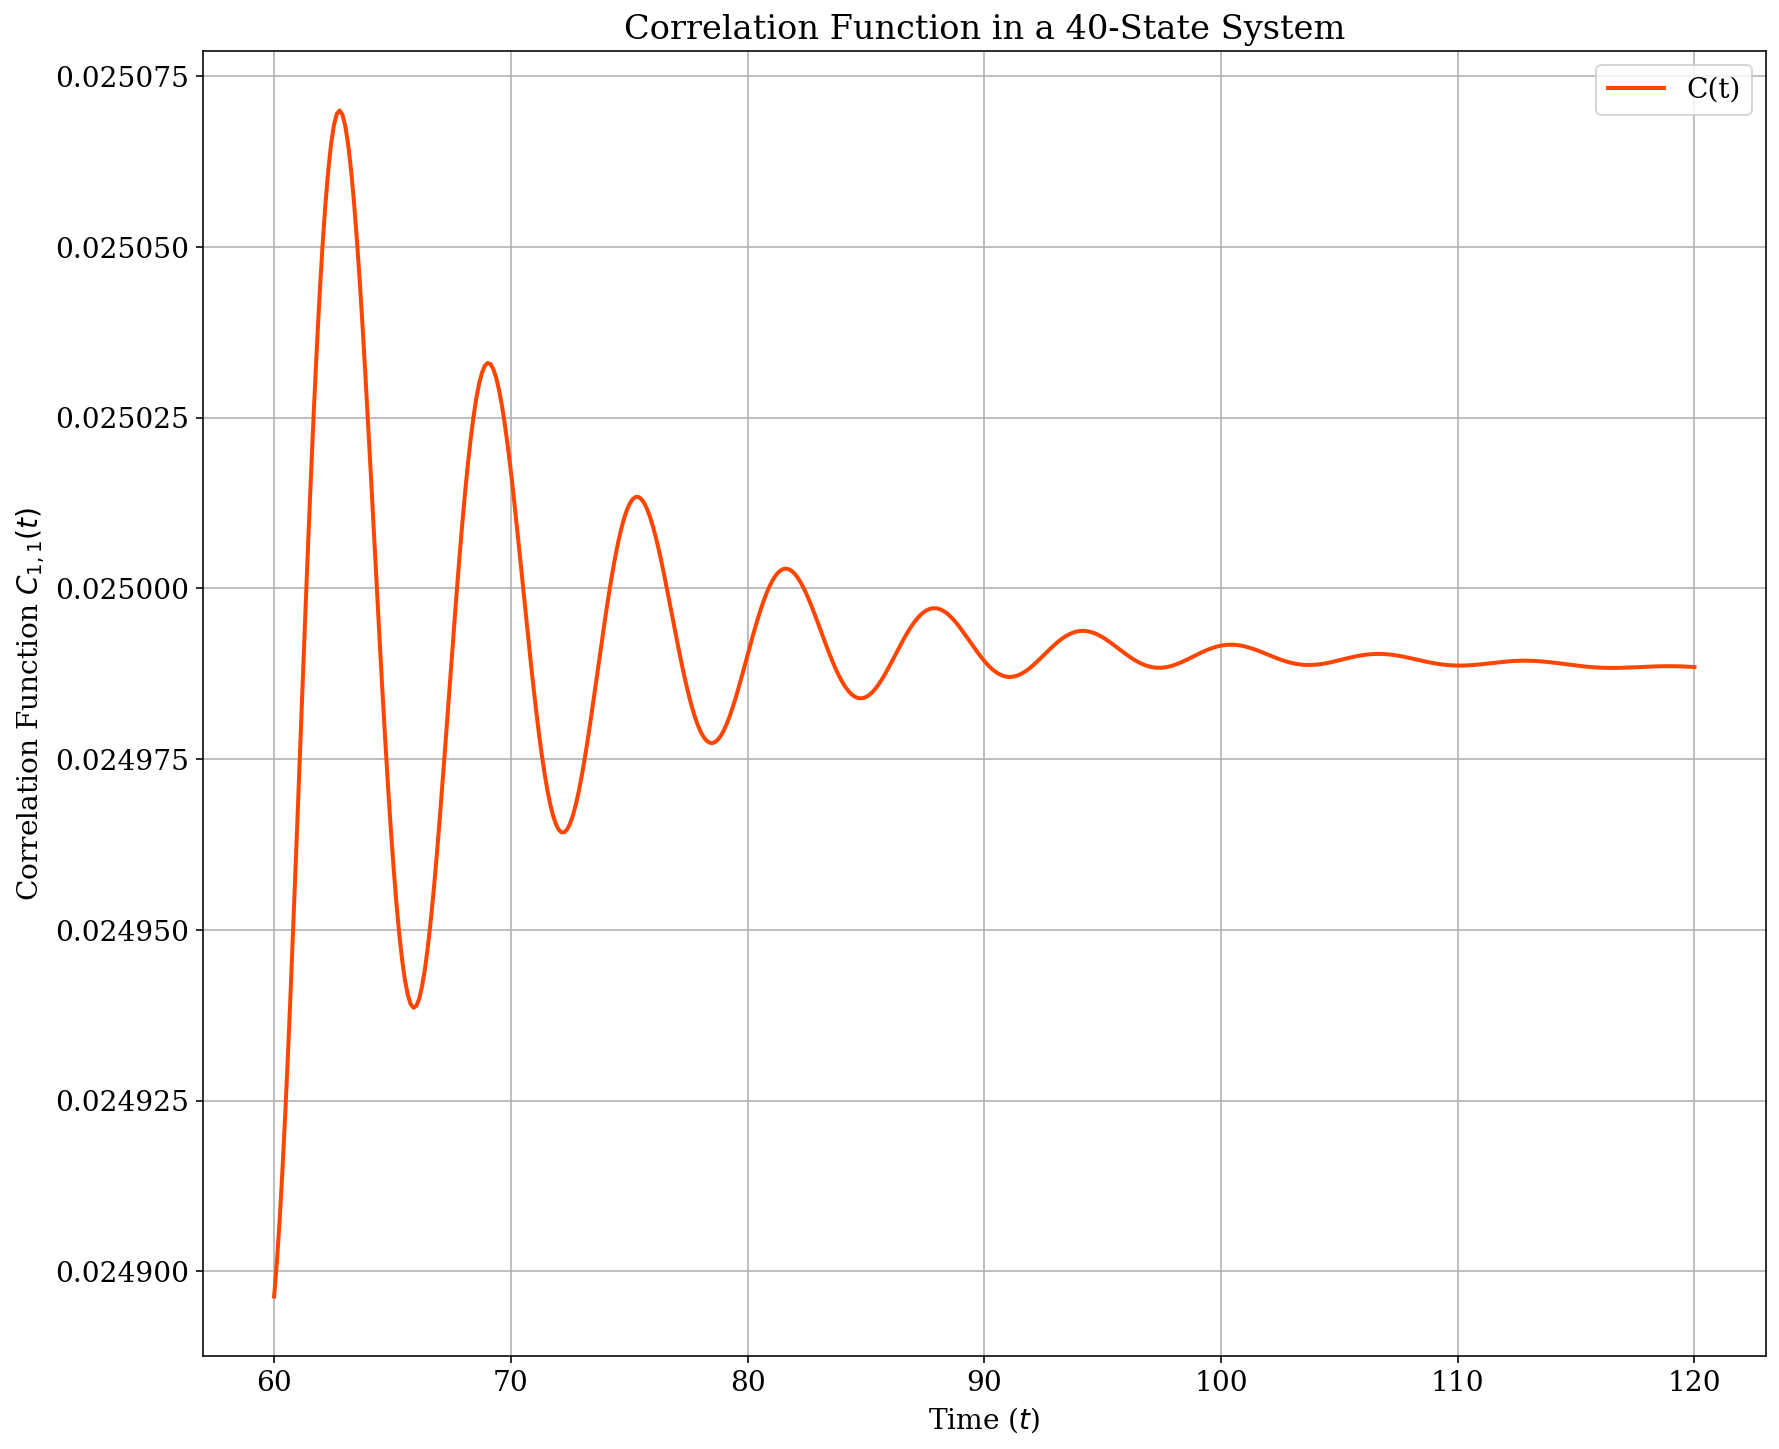

In [276]:
num_states = str(x)

fig, ax = plt.subplots(figsize = (14, 12))
plt.plot(times, correlation_values, color = "orangered", linewidth=2, label='C(t)')
plt.xlabel(r'Time ($t$)')
plt.ylabel(r'Correlation Function $C_{1,1}(t)$')
plt.title('Correlation Function in a '+ num_states +'-State System')
plt.legend()
plt.grid()
plt.show()

In [277]:
x_i2 = np.abs(np.sort(eigvals)[-4].imag)
x_r2 = np.abs(np.sort(eigvals)[-4].real)

In [278]:
x_r2

0.4105935315464033

In [279]:
x_i2

1.9743269125844767

In [280]:
# characteristic timescales
tau = 1/x_r2
tau

2.4354986700198045

This tells us that using the first nontrivial eigenvalue is the correct choice. Now we can work on creating the fitting function.

In [281]:
peaks = scipy.signal.find_peaks(correlation_values)

In [300]:
from scipy import optimize

def exp(t, A, lbda):
    r"""y(t) = A \cdot \exp(-\lambda t)"""
    return A * np.exp(-lbda * t)

def cos(t, omega, phi):
    r"""y(t) = \cos(\omega \cdot t + phi)"""
    return np.cos(omega * t + phi)

def damped_cos(t, A, lbda, omega, phi, C):
    r"""y(t) = A \cdot \exp(-\lambda t) \cdot \left( \cos \left( \omega t + \phi ) \right) + C"""
    return exp(t, A, lbda) * cos(t, omega, phi) + C

def exp_true(t, A, lbda, C):
    r"""y(t) = A \cdot \exp(-\lambda t)"""
    return A * np.exp(-lbda * t) + C

t = times
lbda = x_r
omega = x_i
A = 0.05
phi = 0.1
C = 0.025

exp_cos_vals = damped_cos(t, A, x_r, x_i, phi, C)
exp_vals = exp_true(t, A, lbda, C)

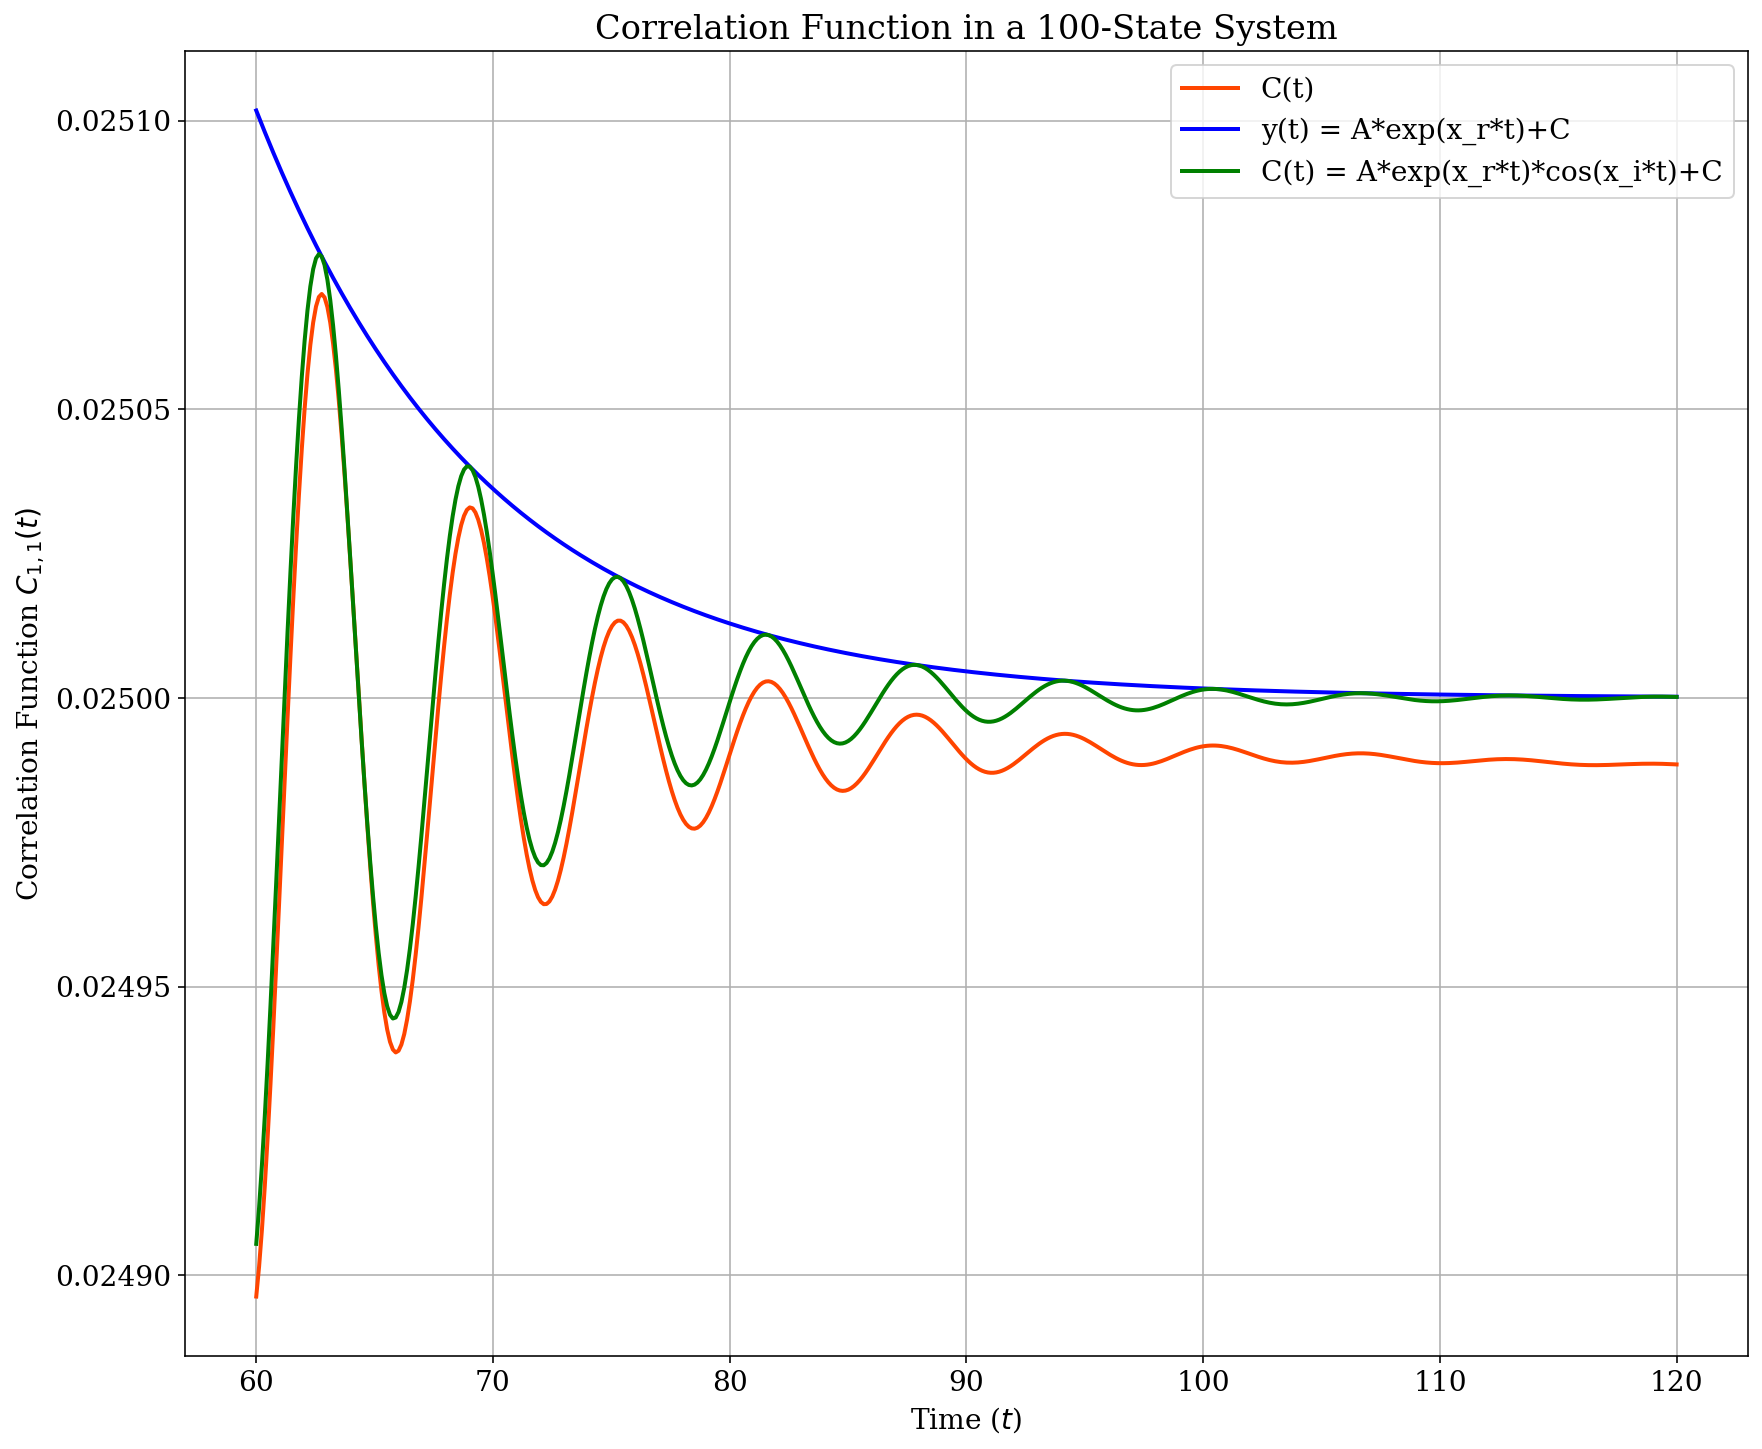

In [301]:
fig, ax = plt.subplots(figsize = (14, 12))
plt.plot(times, correlation_values, color = "orangered", linewidth=2, label='C(t)')
plt.plot(times, exp_vals, color = "blue", linewidth=2, label='y(t) = A*exp(x_r*t)+C')
plt.plot(times, exp_cos_vals, color = "green", linewidth=2, label='C(t) = A*exp(x_r*t)*cos(x_i*t)+C')
plt.xlabel(r'Time ($t$)')
plt.ylabel(r'Correlation Function $C_{1,1}(t)$')
plt.title('Correlation Function in a 100-State System')
plt.legend()
plt.grid()
plt.show()
fig.savefig('40_expcos.png')

The purpose of running this segment of the code is to find the optimal number of states and find the regime where you capture the most oscillations. We want to be able to run this within a reaasonable amount of time for our ATP-varying versions of the simulation.

## ATP-varying version

Here, we implement a finite-state ($N = 40$) Markov process model with ATP consumption. We are going to add a new parameter $n_{ATP}$ as the number of ATP molecules in the environment. As the simulation runs, ATP is going to be consumed along a single edge in the network. So ATP will be depleted over time, but the thermodynamic force of the system will be fixed.

We are interested in examining the relationship between ATP level and oscillation coherence. We expect to see a change in coherence over time as ATP runs out.

In [ ]:
n_ATP = 1000
n_ADP = 0

while n_ATP > 0:
    